# Data Preparation

## Import Libraries

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style = 'darkgrid')

## Import Data

In [3]:
loan_data_backup = pd.read_csv('C:/pandas/loan_data_2007_2014.csv')

In [4]:
loan_data = loan_data_backup.copy()

In [5]:
loan_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

## General Preprocessing

### Preprocessing few continuous variables

#### emp_lenght Column

In [7]:
loan_data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [8]:
def clean_emp_length(dataset, old_col, new_col):
    dataset[new_col] = dataset[old_col].str.replace('+ years', '')
    dataset[new_col] = dataset[new_col].str.replace('< 1 year', '0')
    dataset[new_col] = dataset[new_col].str.replace('n/a', '0')
    dataset[new_col] = dataset[new_col].str.replace(' years', '')
    dataset[new_col] = dataset[new_col].str.replace(' year', '')
    dataset[new_col] = pd.to_numeric(dataset[new_col])

In [9]:
clean_emp_length(loan_data, 'emp_length', 'emp_length_int')

In [10]:
loan_data['emp_length_int'].unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7., nan])

In [11]:
type(loan_data['emp_length_int'][0])

numpy.float64

### Term Column

In [12]:
loan_data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [13]:
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace('months', ''))

In [14]:
type(loan_data['term_int'][0])

numpy.int64

### Earliest_cr_line_date Column

In [15]:
def to_datetime_with_month_diff(dataset, old_col, new_col, format = None, date = None):
    if date != None:
        dataset[new_col] = ((pd.to_datetime(date).year - dataset[old_col].dt.year) * 12 +
                             (pd.to_datetime(date).month - dataset[old_col].dt.month))
    else:
        dataset[new_col] = pd.to_datetime(dataset[old_col], format = format)

In [16]:
to_datetime_with_month_diff(loan_data, 'earliest_cr_line', 'earliest_cr_line_date', format = '%b-%y')

In [17]:
type(loan_data['earliest_cr_line_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [18]:
#  calculates the number of months between each borrower's earliest reported credit line date and reference date '2017-12-01'
to_datetime_with_month_diff(loan_data, 'earliest_cr_line_date', 'mths_since_earliest_cr_line', date = '2017-12-01')

In [19]:
loan_data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

```
Since there are negative values, it indicates that some 'earliest_cr_line_date' values are later than '2017-12-01'. To handle this, we replace all negative values with the maximum value of the column.
```

In [20]:
loan_data.loc[loan_data['mths_since_earliest_cr_line']<0, 'mths_since_earliest_cr_line'] = loan_data['mths_since_earliest_cr_line'].max()

In [21]:
min(loan_data['mths_since_earliest_cr_line'])

73.0

### Issue_d_date Column

In [22]:
to_datetime_with_month_diff(loan_data, 'issue_d', 'issue_d_date', format = '%b-%y')

In [23]:
# Calculate the number of months between the loan issue date and reference date '2017-12-01' 
to_datetime_with_month_diff(loan_data, 'issue_d_date', 'mths_since_issue_d', date = '2017-12-01')

In [24]:
loan_data['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

### Preprocessing few discrete variables

In [25]:
loan_data.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'verificatio

In [26]:
columns = ['grade', 'sub_grade', 'home_ownership', 
           'verification_status', 'loan_status', 'purpose', 
           'addr_state', 'initial_list_status']

loan_data_dummies = []
for col in columns:
    loan_data_dummies.append(pd.get_dummies(loan_data[col], prefix = col, prefix_sep = ':'))

In [27]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [28]:
type(loan_data_dummies)

pandas.core.frame.DataFrame

In [29]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis = 1)

In [30]:
loan_data.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       ...
       'addr_state:TX', 'addr_state:UT', 'addr_state:VA', 'addr_state:VT',
       'addr_state:WA', 'addr_state:WI', 'addr_state:WV', 'addr_state:WY',
       'initial_list_status:f', 'initial_list_status:w'],
      dtype='object', length=207)

### Check for missing values and clean

<Axes: >

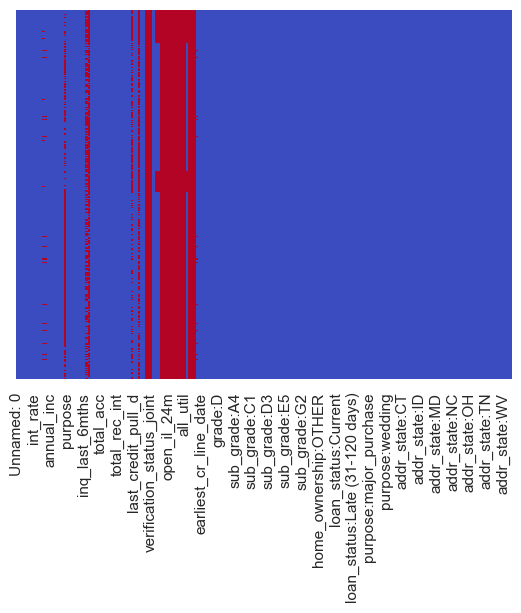

In [31]:
sns.heatmap(loan_data.isnull(), yticklabels = False, cbar = False, cmap = 'coolwarm')

In [32]:
loan_data['total_rev_hi_lim'] = loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'])

In [33]:
def check_null(dataset, col):
    return dataset[col].isnull().sum()

In [34]:
check_null(loan_data, 'total_rev_hi_lim')

0

In [35]:
loan_data['annual_inc'] = loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean())

In [36]:
check_null(loan_data, 'annual_inc')

0

In [37]:
def fillna_0(dataset, cols):
    for col in cols:
        if dataset[col].isnull().sum() > 0:
            dataset[col] = dataset[col].fillna(0)
        else:
            pass

In [38]:
na_columns = ['mths_since_earliest_cr_line', 'acc_now_delinq', 'total_acc', 'pub_rec', 'open_acc', 'inq_last_6mths', 
              'delinq_2yrs', 'emp_length_int']

In [39]:
fillna_0(loan_data, na_columns)

In [40]:
check_null(loan_data, na_columns)

mths_since_earliest_cr_line    0
acc_now_delinq                 0
total_acc                      0
pub_rec                        0
open_acc                       0
inq_last_6mths                 0
delinq_2yrs                    0
emp_length_int                 0
dtype: int64

# PD model

## Feature Selection
* Dependent Variable. Good/Bad (Default) Definition. Default and Non-default Accounts

In [41]:
loan_data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [42]:
# Calculate the relative proportion of each unique value in the 'loan_status' column.
loan_data['loan_status'].value_counts() / loan_data['loan_status'].count()

loan_status
Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: count, dtype: float64

In [43]:
# Create the 'good_bad' column to classify loans into 'good' and 'bad' categories based on the loan status.
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                               'Does not meet the credit policy. Status:Charged Off',
                                                               'Late (16-30 days)']), 0, 1)

In [44]:
loan_data['good_bad']

0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: good_bad, Length: 466285, dtype: int32

### Splitting Data

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(
    loan_data.drop('good_bad', axis = 1), loan_data['good_bad'], test_size = 0.2, random_state = 42)

In [47]:
loan_data_inputs_train.shape

(373028, 207)

In [48]:
loan_data_targets_train.shape

(373028,)

In [49]:
loan_data_inputs_test.shape

(93257, 207)

In [50]:
loan_data_targets_test.shape

(93257,)

### Data Preparation

In [52]:
# df_inputs_prepr = loan_data_inputs_train
# df_targets_prepr = loan_data_targets_train

In [144]:
# Make sure the test dataset have the same dummies as train dataset 
# do it when finish doing the dummies for train dataset
df_inputs_prepr = loan_data_inputs_test
df_targets_prepr = loan_data_targets_test

### Preprocessing Discrete Variables: Automating Calculations

In [145]:
def woe_discrete(dataset, discrete_variable_name, good_bad_variable_dataset):
    dataset = pd.concat([dataset[discrete_variable_name], good_bad_variable_dataset], axis = 1)
    dataset = pd.concat([dataset.groupby(dataset.columns.values[0], as_index = False)[dataset.columns.values[1]].count(),
                dataset.groupby(dataset.columns.values[0], as_index = False)[dataset.columns.values[1]].mean()], axis = 1)
    dataset = dataset.iloc[:, [0,1,3]]
    dataset.columns = [dataset.columns.values[0], 'n_obs', 'prop_good']
    dataset['prop_n_obs'] = dataset['n_obs'] / dataset['n_obs'].sum()
    dataset['n_good'] = dataset['prop_good'] * dataset['n_obs']
    dataset['n_bad'] = (1 - dataset['prop_good']) * dataset['n_obs']
    dataset['prop_n_good'] = dataset['n_good'] / dataset['n_good'].sum()
    dataset['prop_n_bad'] = dataset['n_bad'] / dataset['n_bad'].sum()
    dataset['WoE'] = np.log(dataset['prop_n_good'] / dataset['prop_n_bad'])
    dataset = dataset.sort_values(['WoE'])
    dataset = dataset.reset_index(drop = True)
    dataset['diff_prop_good'] = dataset['prop_good'].diff().abs()
    dataset['diff_WoE'] = dataset['WoE'].diff().abs()
    dataset['IV'] = (dataset['prop_n_good'] - dataset['prop_n_bad']) * dataset['WoE']
    dataset['IV'] = dataset['IV'].sum()
    return dataset

In [146]:
df_temp = woe_discrete(df_inputs_prepr, 'grade', df_targets_prepr)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,668,0.729042,0.007163,487.0,181.0,0.005782,0.020051,-1.243564,NaN,NaN,0.281949
1,F,2699,0.799555,0.028942,2158.0,541.0,0.025620,0.059931,-0.849813,0.070513,0.393751,0.281949
2,E,7145,0.829531,0.076616,5927.0,1218.0,0.070367,0.134929,-0.651023,0.029976,0.198790,0.281949
3,D,15390,0.863938,0.165028,13296.0,2094.0,0.157853,0.231971,-0.384944,0.034406,0.266079,0.281949
4,C,25048,0.896040,0.268591,22444.0,2604.0,0.266461,0.288468,-0.079356,0.032102,0.305587,0.281949
5,B,27199,0.931211,0.291656,25328.0,1871.0,0.300700,0.207267,0.372106,0.035171,0.451463,0.281949
6,A,15108,0.965714,0.162004,14590.0,518.0,0.173216,0.057383,1.104785,0.034503,0.732679,0.281949


### Preprocessing Discrete Variables: Visualizing Results


In [147]:
def plot_by_woe(df_WoE, rotation_x_labels = 0):
    x = np.array(df_WoE.iloc[:,0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize = (18,6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_x_labels)

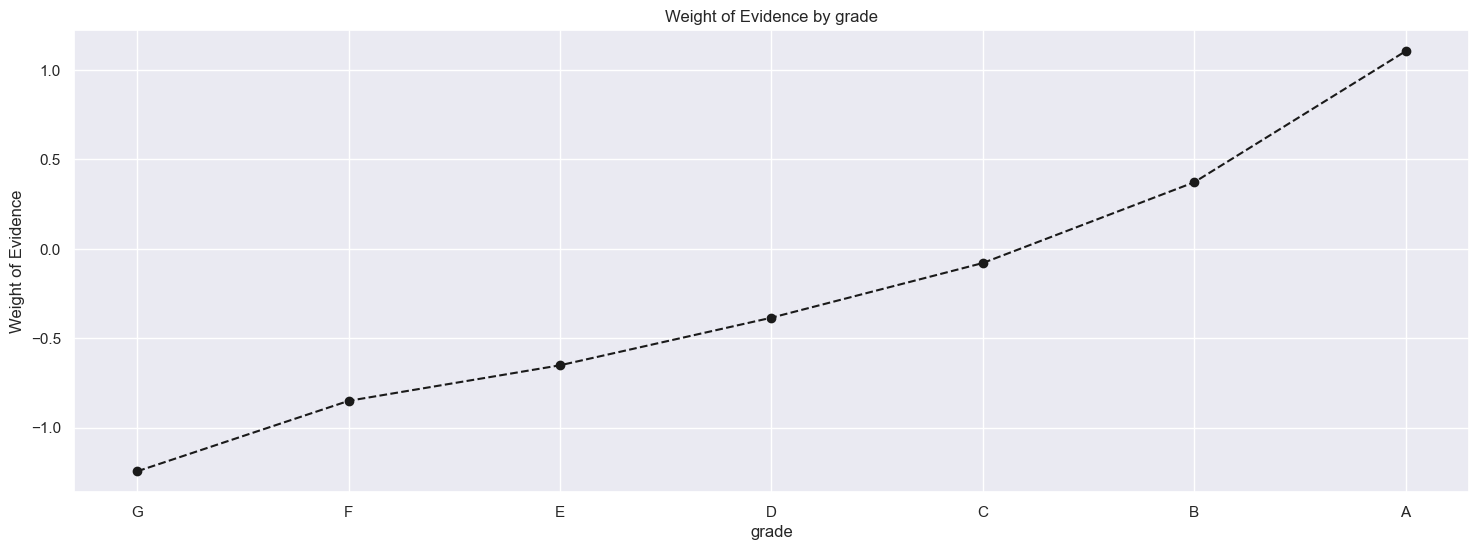

In [148]:
plot_by_woe(df_temp)

In [149]:
df_temp = woe_discrete(df_inputs_prepr, 'home_ownership', df_targets_prepr)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,45,0.777778,0.000483,35.0,10.0,0.000416,0.001108,-0.980568,NaN,NaN,0.023679
1,NONE,10,0.800000,0.000107,8.0,2.0,0.000095,0.000222,-0.847037,0.022222,0.133531,0.023679
2,RENT,37874,0.887944,0.406125,33630.0,4244.0,0.399264,0.470145,-0.163419,0.087944,0.683618,0.023679
3,OWN,8409,0.901891,0.090170,7584.0,825.0,0.090039,0.091392,-0.014918,0.013947,0.148500,0.023679
4,MORTGAGE,46919,0.915898,0.503115,42973.0,3946.0,0.510186,0.437133,0.154539,0.014007,0.169457,0.023679


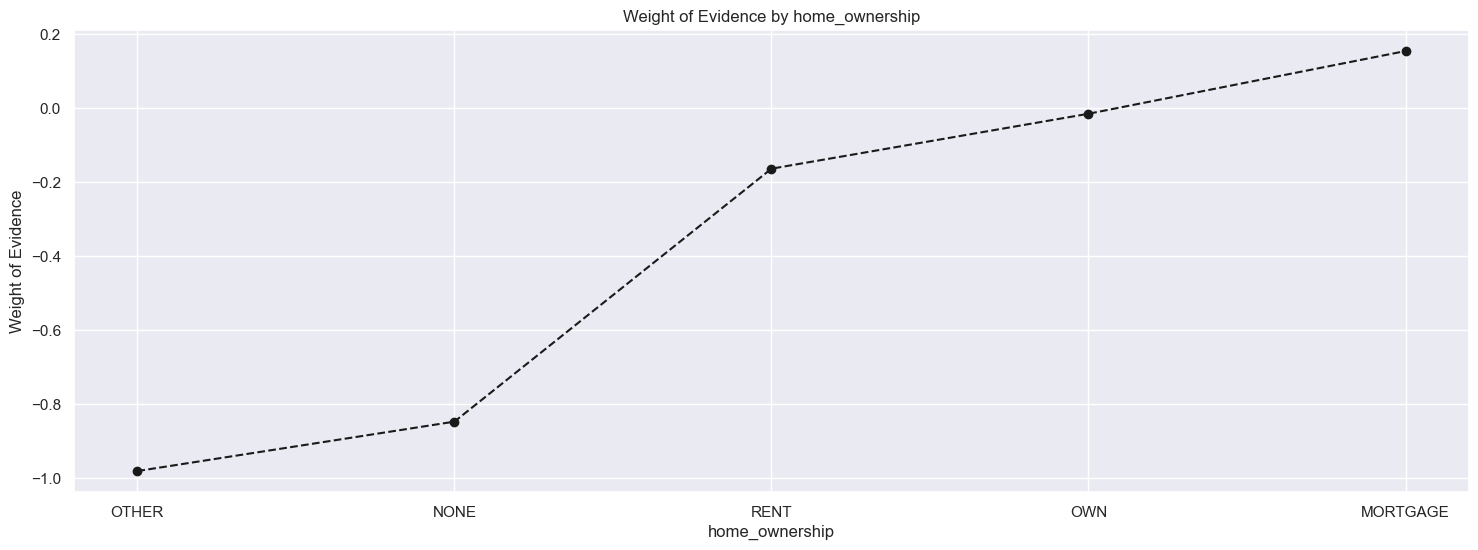

In [150]:
plot_by_woe(df_temp)

In [151]:
def combined_discrete_columns(dataset, col_groups):
    for cols, new_col in col_groups:
        dataset[new_col] = sum([dataset[col] for col in cols])

In [152]:
# Combining categories within a variable based on their similar Weight of Evidence (WOE) values and the number of observations
# to simplify the feature and reduce redundancy in the model
homeowner_group = [(['home_ownership:RENT', 'home_ownership:OTHER', 
                'home_ownership:NONE', 'home_ownership:ANY'], 'home_ownership:RENT_OTHER_NONE_ANY')]

combined_discrete_columns(df_inputs_prepr, homeowner_group)

In [153]:
df_inputs_prepr['addr_state'].unique()

array(['CA', 'IN', 'AZ', 'MI', 'PA', 'MO', 'CT', 'IL', 'SC', 'VA', 'NY',
       'FL', 'TX', 'NC', 'NM', 'NJ', 'KY', 'DE', 'OK', 'CO', 'OH', 'GA',
       'LA', 'WA', 'AL', 'TN', 'MD', 'NV', 'MN', 'RI', 'NH', 'MA', 'MS',
       'UT', 'WV', 'HI', 'KS', 'OR', 'WY', 'WI', 'AK', 'DC', 'AR', 'MT',
       'SD', 'VT', 'IA', 'ID', 'ME', 'NE'], dtype=object)

In [154]:
df_temp = woe_discrete(df_inputs_prepr, 'addr_state', df_targets_prepr)
df_temp

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,ID,2,0.500000,0.000021,1.0,1.0,0.000012,0.000111,-2.233331,NaN,NaN,inf
1,NV,1298,0.875963,0.013919,1137.0,161.0,0.013499,0.017835,-0.278587,0.375963,1.954744,inf
2,HI,486,0.882716,0.005211,429.0,57.0,0.005093,0.006314,-0.214925,0.006753,0.063662,inf
3,FL,6426,0.883598,0.068906,5678.0,748.0,0.067411,0.082863,-0.206380,0.000882,0.008546,inf
4,AL,1182,0.884095,0.012675,1045.0,137.0,0.012407,0.015177,-0.201540,0.000497,0.004840,inf
5,DE,208,0.884615,0.002230,184.0,24.0,0.002184,0.002659,-0.196449,0.000521,0.005091,inf
6,NJ,3676,0.884657,0.039418,3252.0,424.0,0.038609,0.046970,-0.196039,0.000042,0.000410,inf
7,LA,1130,0.885841,0.012117,1001.0,129.0,0.011884,0.014290,-0.184389,0.001183,0.011650,inf
8,NY,8031,0.894658,0.086117,7185.0,846.0,0.085302,0.093719,-0.094100,0.008817,0.090289,inf
9,RI,403,0.895782,0.004321,361.0,42.0,0.004286,0.004653,-0.082123,0.001123,0.011977,inf


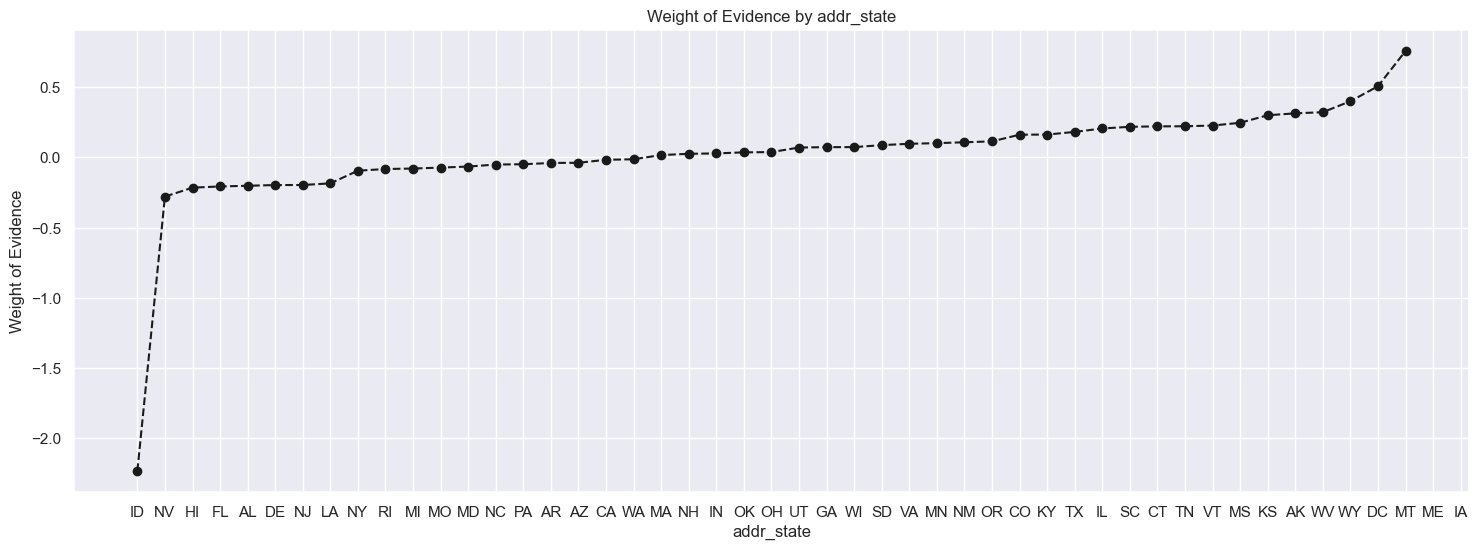

In [155]:
plot_by_woe(df_temp)

In [156]:
# Since the 'addr_state:ND' category was dropped earlier in our data, 
# we are adding it back in this case.
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

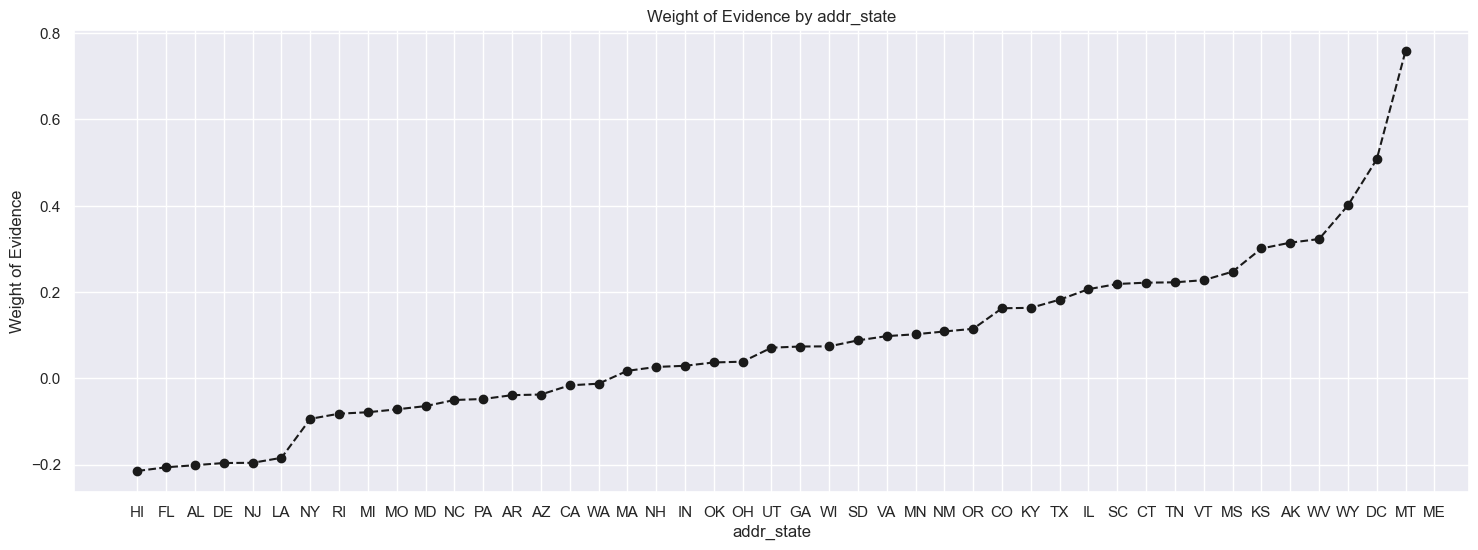

In [157]:
plot_by_woe(df_temp.iloc[2:-2,:])

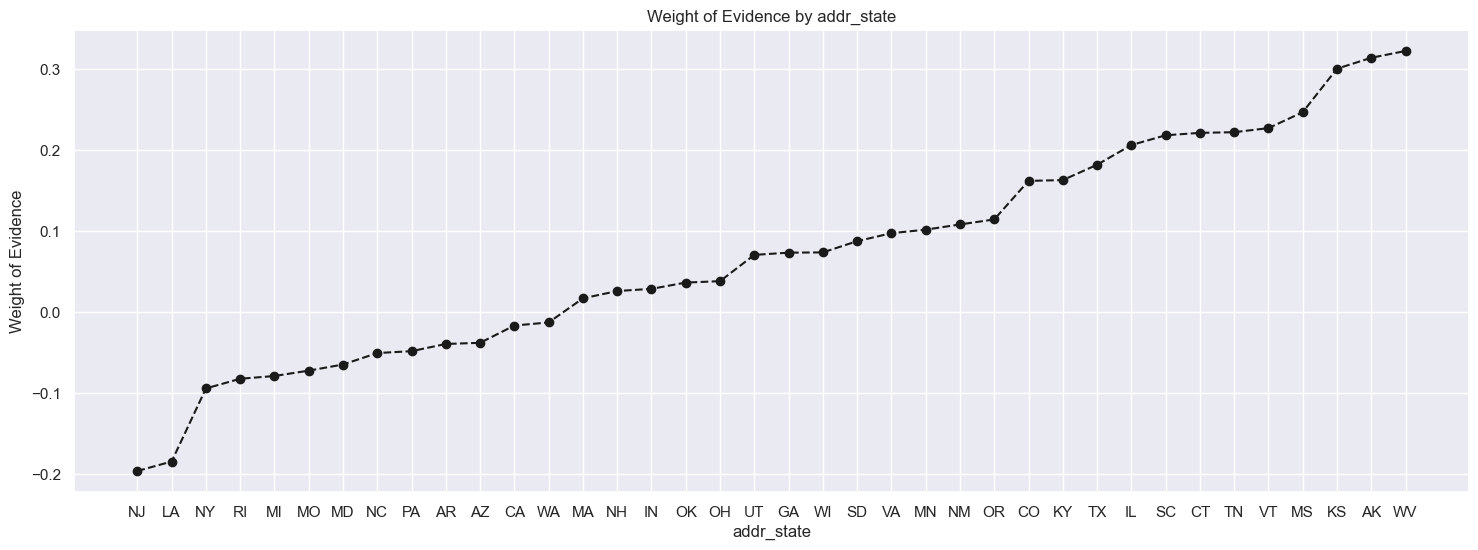

In [158]:
plot_by_woe(df_temp.iloc[6:-6,:])

In [159]:
# Combining categories within a variable based on their similar Weight of Evidence (WOE) values and the number of observations
# to simplify the feature and reduce redundancy in the model

addr_state_group = [(['addr_state:ND', 'addr_state:NE', 'addr_state:IA', 
                      'addr_state:NV', 'addr_state:FL', 'addr_state:HI', 'addr_state:AL'], 'addr_state:ND_NE_IA_NV_FL_HI_AL'),
                    (['addr_state:NM', 'addr_state:VA'], 'addr_state:NM_VA'),
                    (['addr_state:OK', 'addr_state:TN', 'addr_state:MO',
                      'addr_state:LA', 'addr_state:MD', 'addr_state:NC'], 'addr_state:OK_TN_MO_LA_MD_NC'),
                    (['addr_state:UT', 'addr_state:KY', 'addr_state:AZ', 'addr_state:NJ'], 'addr_state:UT_KY_AZ_NJ'),
                    (['addr_state:AR', 'addr_state:MI', 'addr_state:PA',
                      'addr_state:OH', 'addr_state:MN'], 'addr_state:AR_MI_PA_OH_MN'),
                    (['addr_state:RI', 'addr_state:MA', 'addr_state:DE',
                      'addr_state:SD', 'addr_state:IN'], 'addr_state:RI_MA_DE_SD_IN'),
                    (['addr_state:GA', 'addr_state:WA', 'addr_state:OR'], 'addr_state:GA_WA_OR'),
                    (['addr_state:WI', 'addr_state:MT'], 'addr_state:WI_MT'),
                    (['addr_state:IL', 'addr_state:CT'], 'addr_state:IL_CT'),
                    (['addr_state:KS', 'addr_state:SC', 'addr_state:CO',
                      'addr_state:VT', 'addr_state:AK', 'addr_state:MS'], 'addr_state:KS_SC_CO_VT_AK_MS'),
                    (['addr_state:WV', 'addr_state:NH', 'addr_state:WY',
                      'addr_state:DC', 'addr_state:ME', 'addr_state:ID'], 'addr_state:WV_NH_WY_DC_ME_ID')]
                
combined_discrete_columns(df_inputs_prepr, addr_state_group)

In [160]:
df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID']

362514    0
288564    0
213591    0
263083    0
165001    0
         ..
115       0
296284    0
61777     0
91763     0
167512    0
Name: addr_state:WV_NH_WY_DC_ME_ID, Length: 93257, dtype: int32

In [161]:
df_temp = woe_discrete(df_inputs_prepr, 'verification_status', df_targets_prepr)
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,33641,0.885616,0.360734,29793.0,3848.0,0.353710,0.426277,-0.186611,NaN,NaN,0.022632
1,Source Verified,29963,0.910990,0.321295,27296.0,2667.0,0.324065,0.295447,0.092455,0.025374,0.279066,0.022632
2,Not Verified,29653,0.915287,0.317971,27141.0,2512.0,0.322225,0.278276,0.146635,0.004297,0.054180,0.022632


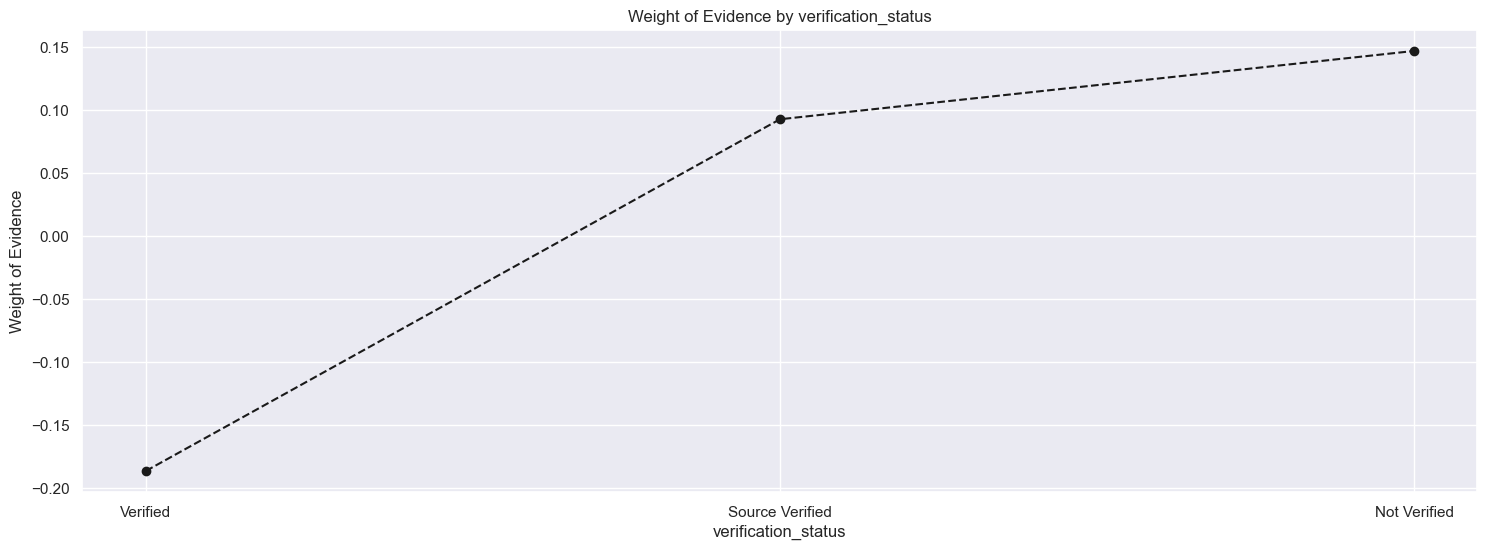

In [162]:
plot_by_woe(df_temp)

In [163]:
df_temp = woe_discrete(df_inputs_prepr, 'purpose', df_targets_prepr)
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,educational,89,0.752809,0.000954,67.0,22.0,0.000795,0.002437,-1.119681,NaN,NaN,0.052699
1,renewable_energy,70,0.771429,0.000751,54.0,16.0,0.000641,0.001772,-1.016936,0.018620,0.102745,0.052699
2,small_business,1431,0.789658,0.015345,1130.0,301.0,0.013416,0.033344,-0.910468,0.018229,0.106467,0.052699
3,medical,918,0.863834,0.009844,793.0,125.0,0.009415,0.013847,-0.385822,0.074177,0.524647,0.052699
4,house,439,0.870159,0.004707,382.0,57.0,0.004535,0.006314,-0.330962,0.006325,0.054860,0.052699
5,other,4806,0.872243,0.051535,4192.0,614.0,0.049768,0.068018,-0.312393,0.002084,0.018569,0.052699
6,wedding,456,0.875000,0.004890,399.0,57.0,0.004737,0.006314,-0.287421,0.002757,0.024972,0.052699
7,vacation,496,0.885081,0.005319,439.0,57.0,0.005212,0.006314,-0.191883,0.010081,0.095538,0.052699
8,moving,602,0.885382,0.006455,533.0,69.0,0.006328,0.007644,-0.188916,0.000301,0.002967,0.052699
9,debt_consolidation,55012,0.899676,0.589897,49493.0,5519.0,0.587593,0.611388,-0.039697,0.014294,0.149220,0.052699


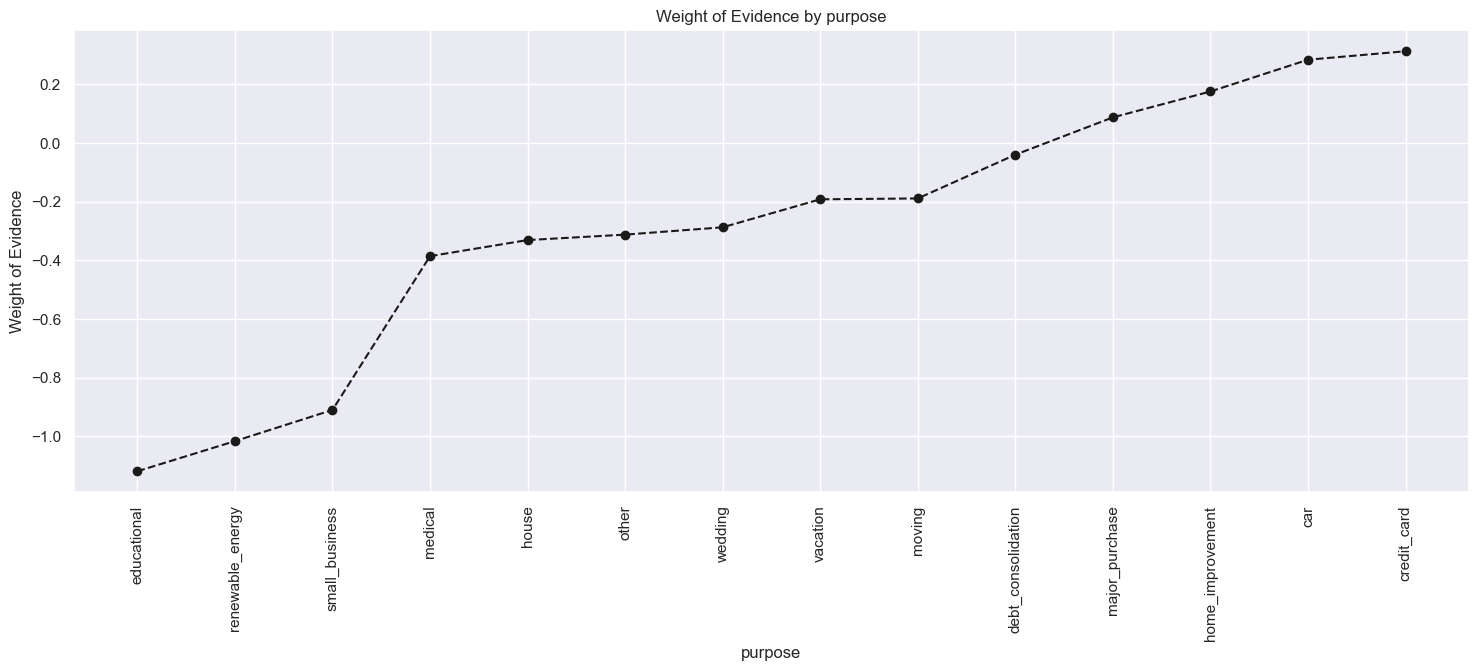

In [164]:
plot_by_woe(df_temp, 90)

In [165]:
# Combining categories within a variable based on their similar Weight of Evidence (WOE) values and the number of observations
# to simplify the feature and reduce redundancy in the model

purpose_group = [(['purpose:educational', 'purpose:small_business', 'purpose:wedding',
                   'purpose:renewable_energy', 'purpose:moving', 'purpose:house'], 'purpose:educ__sm_b__wedd__ren_en__mov__house'),
                 (['purpose:other', 'purpose:medical', 'purpose:vacation'], 'purpose:oth__med__vacation'),
                 (['purpose:major_purchase', 'purpose:car', 'purpose:home_improvement'], 'purpose:major_purch__car__home_impr')]

combined_discrete_columns(df_inputs_prepr, purpose_group)

In [166]:
df_temp = woe_discrete(df_inputs_prepr, 'initial_list_status', df_targets_prepr)
df_temp

,initial_list_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,f,60491,0.890992,0.648648,53897.0,6594.0,0.639879,0.730475,-0.132416,NaN,NaN,0.038249
1,w,32766,0.925746,0.351352,30333.0,2433.0,0.360121,0.269525,0.289780,0.034754,0.422196,0.038249


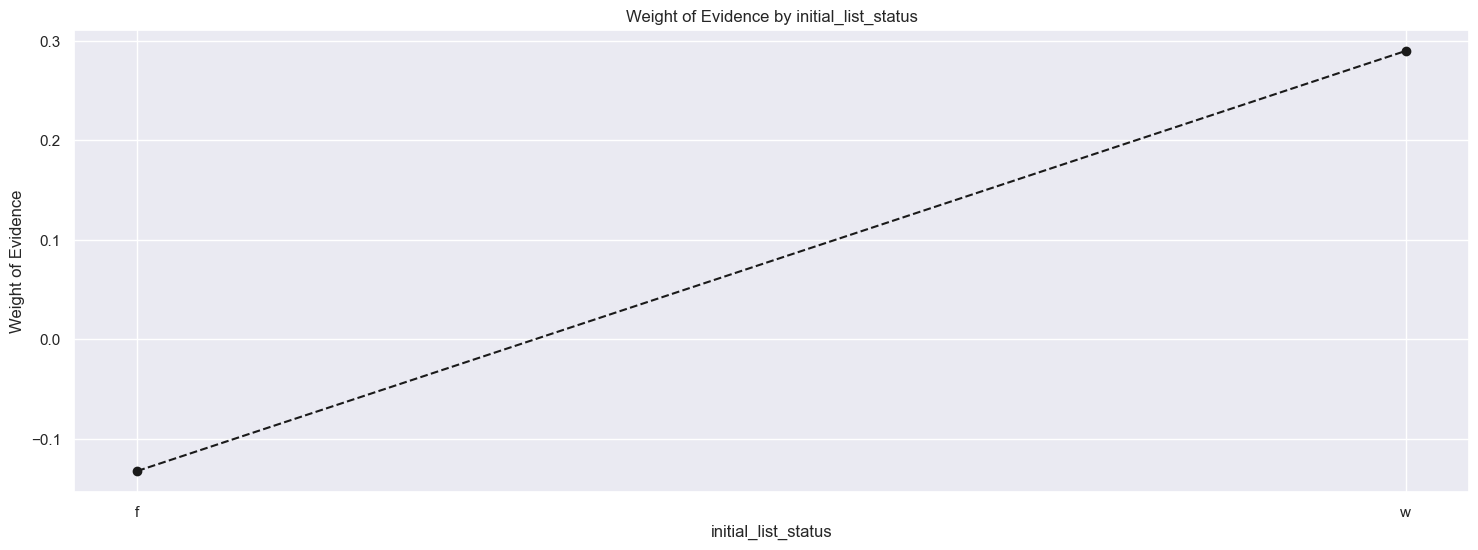

In [167]:
plot_by_woe(df_temp)

### Preprocessing Continuous Variables: Automating Calculations

In [168]:
def woe_ordered_contin(df, discrete_variable_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
                df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0,1,3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1-df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

### Preprocessing Continuous Variables: Creating Dummy Variables

In [169]:
df_temp = woe_ordered_contin(df_inputs_prepr, 'term_int', df_targets_prepr)
df_temp

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,67534,0.912711,0.724171,61639.0,5895.0,0.731794,0.653041,0.113859,NaN,NaN,0.029242
1,60,25723,0.878241,0.275829,22591.0,3132.0,0.268206,0.346959,-0.257451,0.034469,0.37131,0.029242


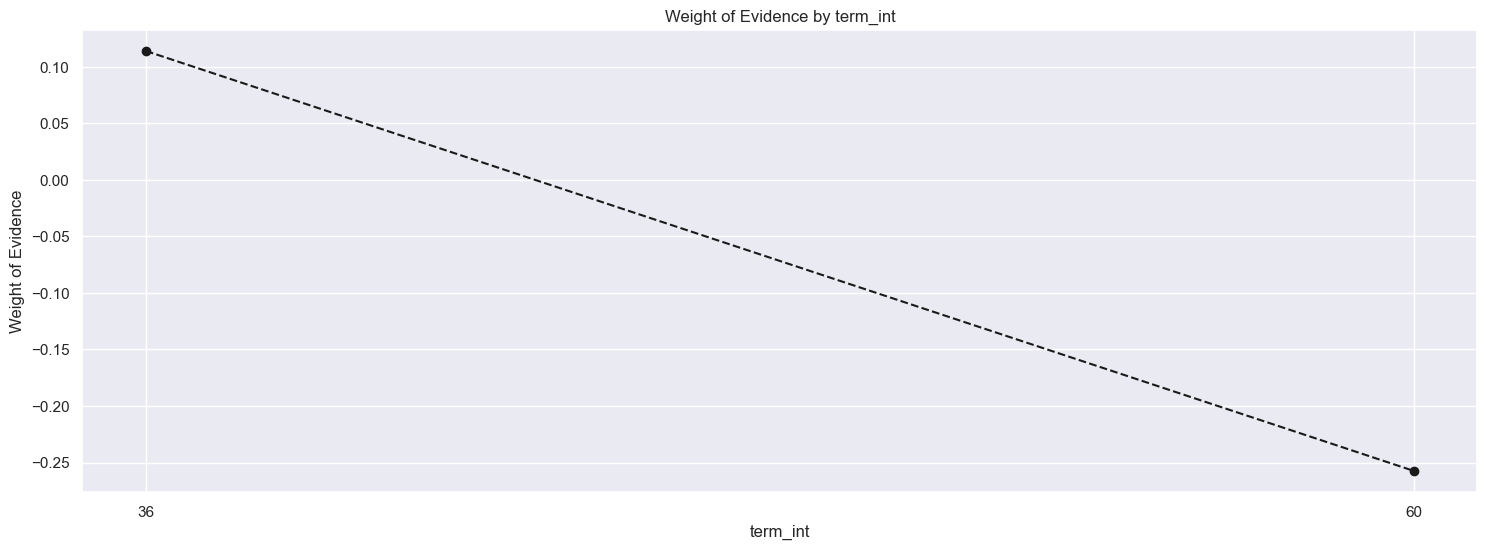

In [170]:
plot_by_woe(df_temp)

In [171]:
# Combining categories within a variable based on their similar Weight of Evidence (WOE) values and the number of observations
# to simplify the feature and reduce redundancy in the model

df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int'] ==36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int'] ==60), 1, 0)

In [172]:
df_temp = woe_ordered_contin(df_inputs_prepr, 'emp_length_int', df_targets_prepr)
df_temp

,emp_length_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,11553,0.889726,0.123883,10279.0,1274.0,0.122035,0.141132,-0.145390,NaN,NaN,0.008283
1,1.0,5968,0.905664,0.063995,5405.0,563.0,0.064170,0.062368,0.028469,0.015938,0.173859,0.008283
2,2.0,8295,0.900422,0.088948,7469.0,826.0,0.088674,0.091503,-0.031409,0.005242,0.059878,0.008283
3,3.0,7391,0.900961,0.079254,6659.0,732.0,0.079057,0.081090,-0.025387,0.000539,0.006022,0.008283
4,4.0,5555,0.903510,0.059567,5019.0,536.0,0.059587,0.059377,0.003521,0.002550,0.028908,0.008283
5,5.0,6172,0.896792,0.066183,5535.0,637.0,0.065713,0.070566,-0.071254,0.006718,0.074775,0.008283
6,6.0,5225,0.891675,0.056028,4659.0,566.0,0.055313,0.062701,-0.125369,0.005117,0.054115,0.008283
7,7.0,5131,0.903333,0.055020,4635.0,496.0,0.055028,0.054946,0.001484,0.011658,0.126854,0.008283
8,8.0,4542,0.902026,0.048704,4097.0,445.0,0.048641,0.049297,-0.013395,0.001307,0.014880,0.008283
9,9.0,3621,0.902513,0.038828,3268.0,353.0,0.038799,0.039105,-0.007866,0.000488,0.005529,0.008283


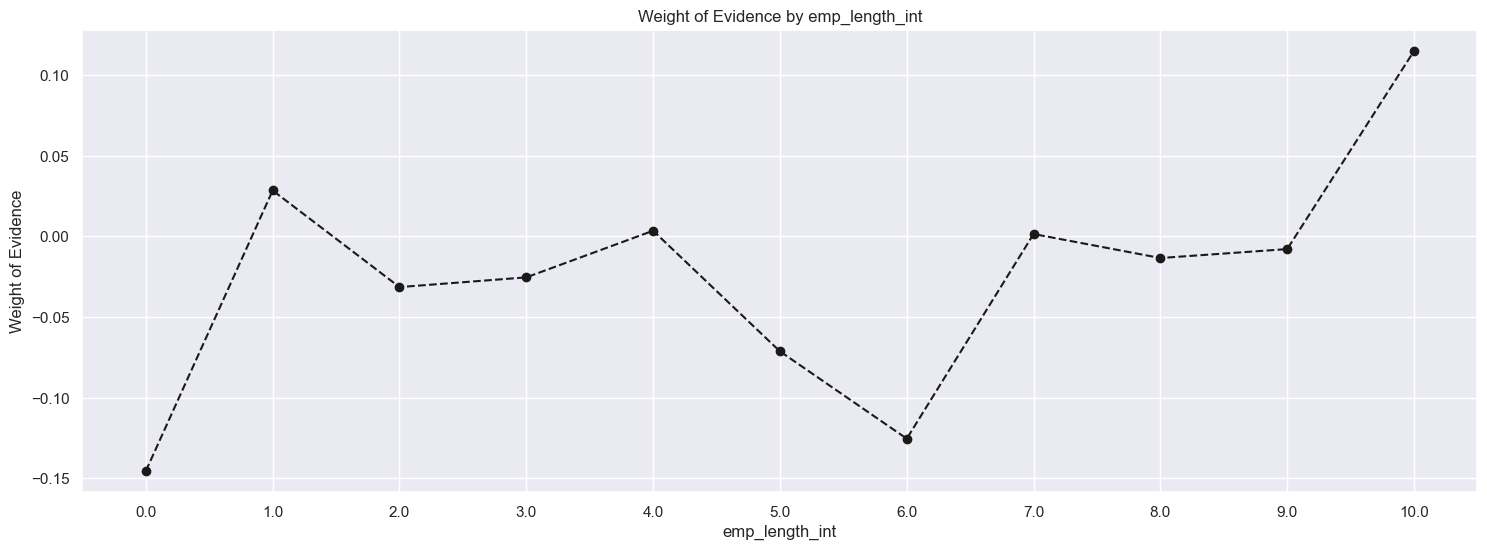

In [173]:
plot_by_woe(df_temp)

In [174]:
def create_dummy_col_with_range(dataset, col, ranges):
    for range, new_col in ranges:
        dataset[new_col] = np.where(dataset[col].isin(range), 1, 0)

In [175]:
def create_dummy_col_wo_range(dataset, col, ranges, method = None):
    for range, new_col in ranges:
        if method == None:
            dataset[new_col] = np.where((dataset[col] >= range[0]) & (dataset[col] <= range[1]), 1, 0)
        else:
            dataset[new_col] = np.where((dataset[col] > range[0]) & (dataset[col] <= range[1]), 1, 0)

In [176]:
# Combining categories within a variable based on their similar Weight of Evidence (WOE) values and the number of observations
# to simplify the feature and reduce redundancy in the model

emp_length_ranges = [(range(0, 1), 'emp_length:0'),
                     (range(1, 2), 'emp_length:1'),
                     (range(2, 5), 'emp_length:2-4'),
                     (range(5, 7), 'emp_length:5-6'),
                     (range(7, 10), 'emp_length:7-9'),
                     (range(10, 11), 'emp_length:10')]

create_dummy_col_with_range(df_inputs_prepr, 'emp_length_int', emp_length_ranges)

In [177]:
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)
df_inputs_prepr['mths_since_issue_d_factor']

362514     (39.6, 41.4]
288564     (37.8, 39.6]
213591     (64.8, 66.6]
263083    (35.91, 37.8]
165001     (57.6, 59.4]
              ...      
115        (70.2, 72.0]
296284     (37.8, 39.6]
61777      (48.6, 50.4]
91763      (50.4, 52.2]
167512     (57.6, 59.4]
Name: mths_since_issue_d_factor, Length: 93257, dtype: category
Categories (50, interval[float64, right]): [(35.91, 37.8] < (37.8, 39.6] < (39.6, 41.4] < (41.4, 43.2] ... (118.8, 120.6] < (120.6, 122.4] < (122.4, 124.2] < (124.2, 126.0]]

In [178]:
df_temp = woe_ordered_contin(df_inputs_prepr, 'mths_since_issue_d_factor', df_targets_prepr)
df_temp

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(35.91, 37.8]",7191,0.960645,0.077109,6908.0,283.0,0.082014,0.031350,0.961657,NaN,NaN,0.20306
1,"(37.8, 39.6]",9752,0.948113,0.104571,9246.0,506.0,0.109771,0.056054,0.672079,0.012532,0.289579,0.20306
2,"(39.6, 41.4]",9506,0.935199,0.101933,8890.0,616.0,0.105544,0.068240,0.436104,0.012914,0.235974,0.20306
3,"(41.4, 43.2]",7240,0.928591,0.077635,6723.0,517.0,0.079817,0.057273,0.331916,0.006608,0.104188,0.20306
4,"(43.2, 45.0]",7217,0.919219,0.077388,6634.0,583.0,0.078761,0.064584,0.198445,0.009373,0.133471,0.20306
5,"(45.0, 46.8]",3104,0.909472,0.033284,2823.0,281.0,0.033515,0.031129,0.073870,0.009747,0.124575,0.20306
6,"(46.8, 48.6]",6197,0.907859,0.066451,5626.0,571.0,0.066793,0.063255,0.054434,0.001613,0.019436,0.20306
7,"(48.6, 50.4]",5821,0.903625,0.062419,5260.0,561.0,0.062448,0.062147,0.004834,0.004234,0.049599,0.20306
8,"(50.4, 52.2]",5021,0.890460,0.053840,4471.0,550.0,0.053081,0.060928,-0.137882,0.013165,0.142716,0.20306
9,"(52.2, 54.0]",4497,0.880142,0.048222,3958.0,539.0,0.046990,0.059710,-0.239553,0.010318,0.101671,0.20306


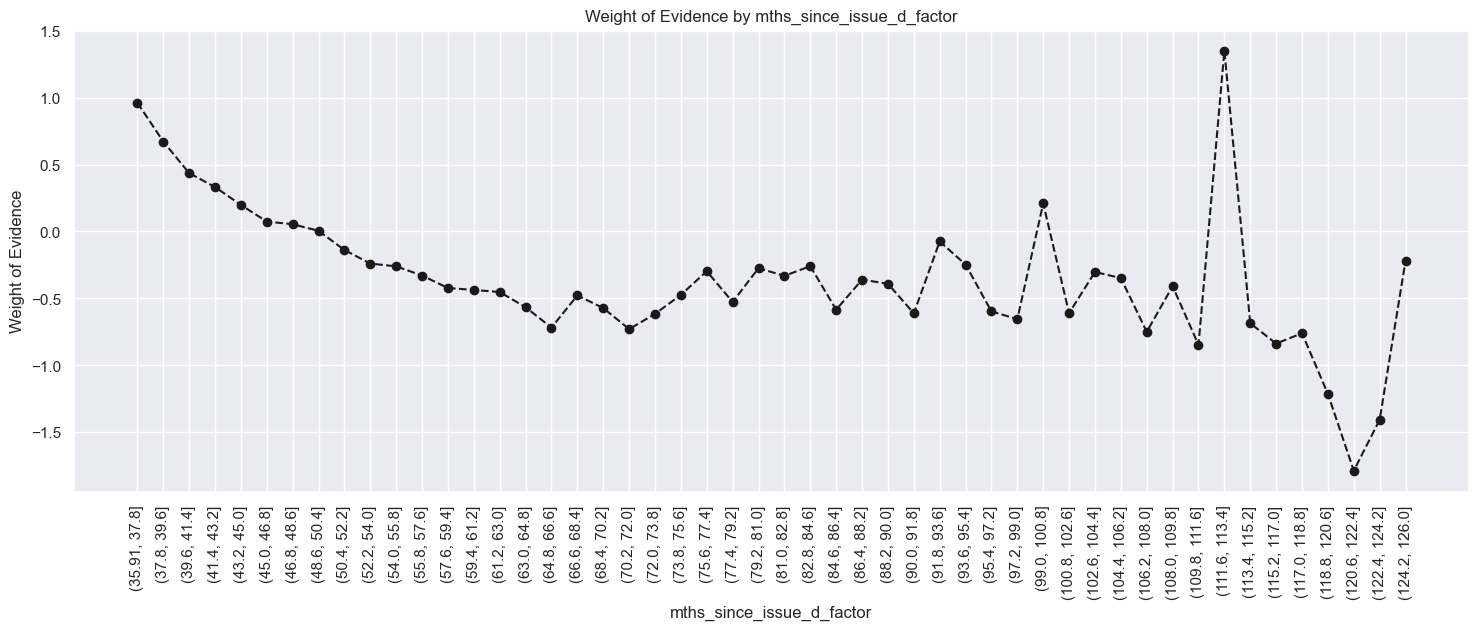

In [179]:
plot_by_woe(df_temp, 90)

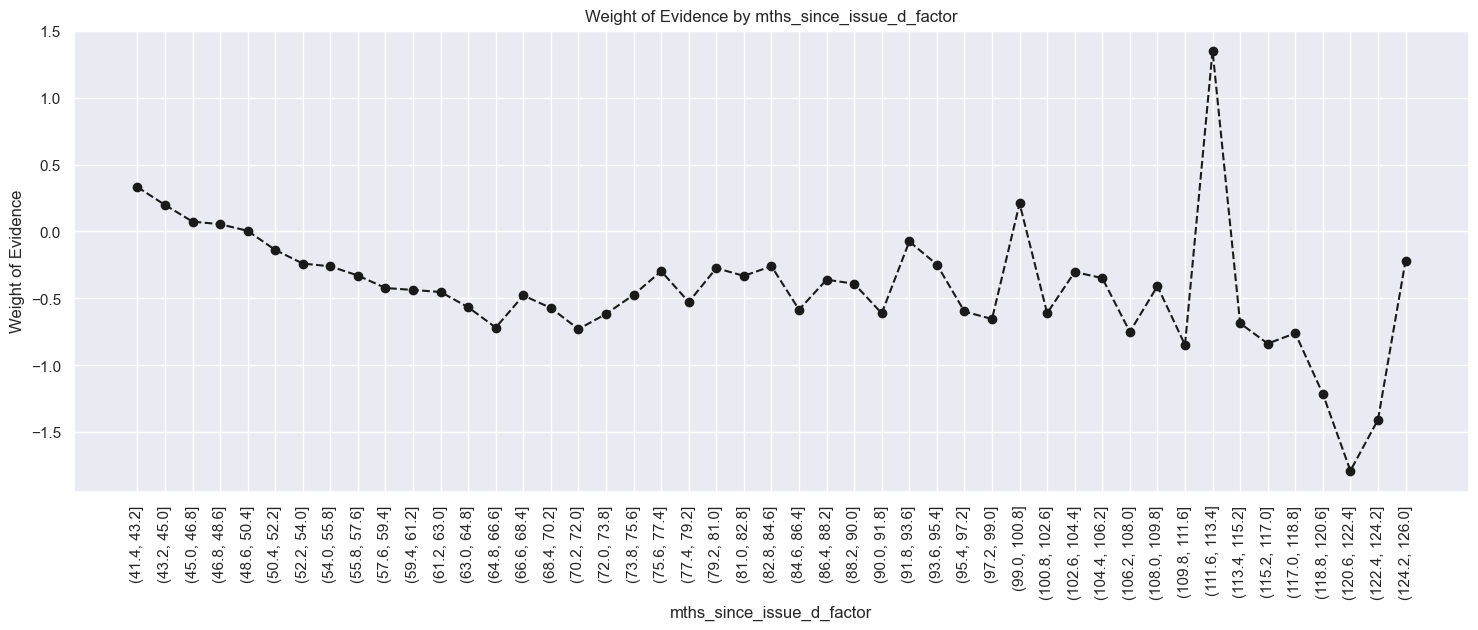

In [180]:
plot_by_woe(df_temp.iloc[3:,:],90)

In [181]:
# Combining categories within a variable based on their similar Weight of Evidence (WOE) values and the number of observations
# to simplify the feature and reduce redundancy in the model

mths_ranges = [(range(38), 'mths_since_issue_d:<38'),
               (range(38,40), 'mths_since_issue_d:38-39'),
               (range(40,42), 'mths_since_issue_d:40-41'),
               (range(42,49), 'mths_since_issue_d:42-48'),
               (range(49,53), 'mths_since_issue_d:49-52'),
               (range(53,65), 'mths_since_issue_d:53-64'),
               (range(65,85), 'mths_since_issue_d:65-84'),
               (range(85, int(df_inputs_prepr['mths_since_issue_d'].max())), 'mths_since_issue_d:>84')]

create_dummy_col_with_range(df_inputs_prepr, 'mths_since_issue_d', mths_ranges)

In [182]:
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'],50)

In [183]:
df_temp = woe_ordered_contin(df_inputs_prepr, 'int_rate_factor', df_targets_prepr)
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.399, 5.833]",198,0.969697,0.002123,192.0,6.0,0.002279,0.000665,1.232405,NaN,NaN,0.364404
1,"(5.833, 6.246]",2086,0.980345,0.022368,2045.0,41.0,0.024279,0.004542,1.676250,0.010648,0.443845,0.364404
2,"(6.246, 6.658]",1974,0.975177,0.021167,1925.0,49.0,0.022854,0.005428,1.437530,0.005168,0.238720,0.364404
3,"(6.658, 7.071]",477,0.949686,0.005115,453.0,24.0,0.005378,0.002659,0.704507,0.025492,0.733023,0.364404
4,"(7.071, 7.484]",804,0.983831,0.008621,791.0,13.0,0.009391,0.001440,1.875018,0.034145,1.170510,0.364404
5,"(7.484, 7.897]",3245,0.968259,0.034796,3142.0,103.0,0.037303,0.011410,1.184555,0.015572,0.690463,0.364404
6,"(7.897, 8.31]",2429,0.955537,0.026046,2321.0,108.0,0.027556,0.011964,0.834291,0.012722,0.350264,0.364404
7,"(8.31, 8.722]",1680,0.970833,0.018015,1631.0,49.0,0.019364,0.005428,1.271797,0.015296,0.437506,0.364404
8,"(8.722, 9.135]",2384,0.947567,0.025564,2259.0,125.0,0.026819,0.013847,0.661033,0.023266,0.610765,0.364404
9,"(9.135, 9.548]",1590,0.983648,0.017050,1564.0,26.0,0.018568,0.002880,1.863574,0.036081,1.202542,0.364404


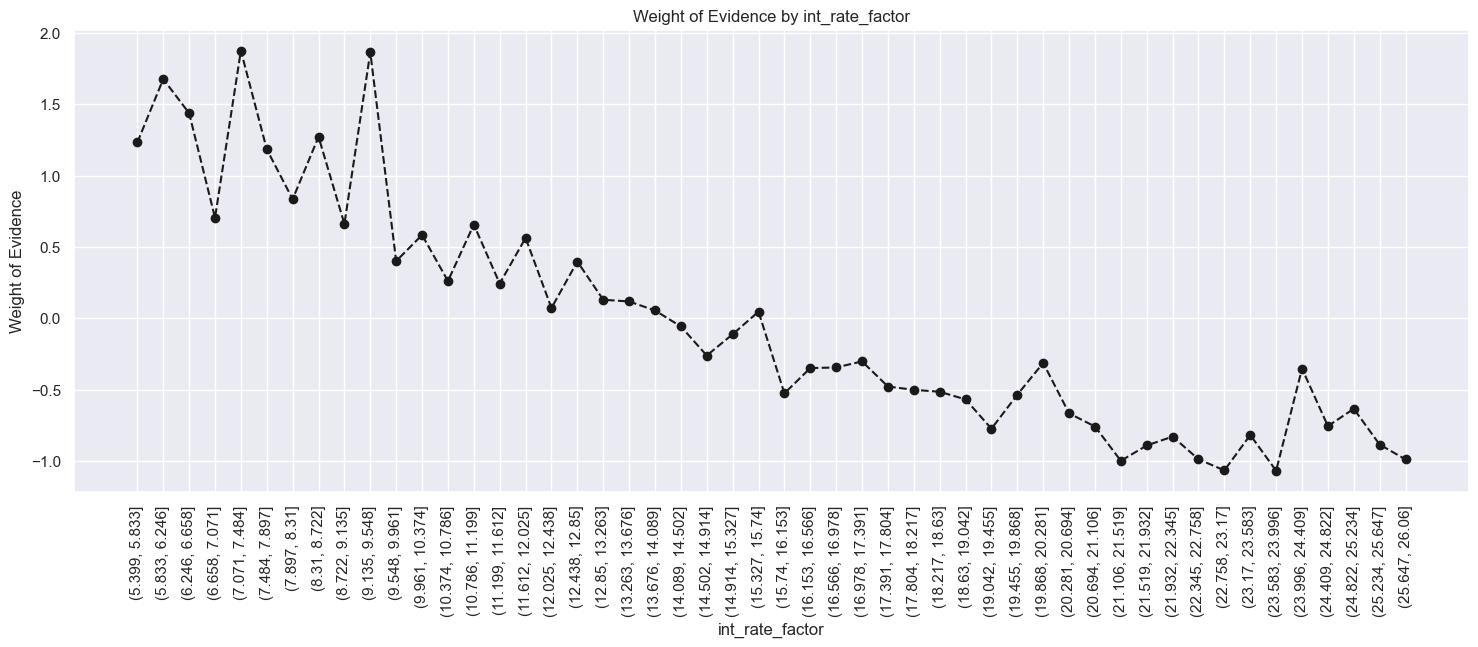

In [184]:
plot_by_woe(df_temp, 90)

In [185]:
# Combining categories within a variable based on their similar Weight of Evidence (WOE) values and the number of observations
# to simplify the feature and reduce redundancy in the model

int_rate_ranges = [((-float('inf'), 9.548), 'int_rate:<9.548'),
                   ((9.548, 12.025), 'int_rate:9.548-12.025'),
                   ((12.025, 15.74), 'int_rate:12.025-15.74'),
                   ((15.74, 20.281), 'int_rate:15.74-20.281'),
                   ((20.281, float('inf')), 'int_rate:>20.281')]

create_dummy_col_wo_range(df_inputs_prepr, 'int_rate', int_rate_ranges)

In [186]:
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'],50)
df_temp = woe_ordered_contin(df_inputs_prepr, 'funded_amnt_factor', df_targets_prepr)
df_temp

,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(465.5, 1190.0]",319,0.887147,0.003421,283.0,36.0,0.003360,0.003988,-0.171403,NaN,NaN,0.019
1,"(1190.0, 1880.0]",800,0.897500,0.008578,718.0,82.0,0.008524,0.009084,-0.063581,0.010353,0.107822,0.019
2,"(1880.0, 2570.0]",1513,0.908130,0.016224,1374.0,139.0,0.016312,0.015398,0.057676,0.010630,0.121257,0.019
3,"(2570.0, 3260.0]",1817,0.900385,0.019484,1636.0,181.0,0.019423,0.020051,-0.031819,0.007744,0.089495,0.019
4,"(3260.0, 3950.0]",1245,0.907631,0.013350,1130.0,115.0,0.013416,0.012740,0.051710,0.007245,0.083528,0.019
5,"(3950.0, 4640.0]",2298,0.893386,0.024642,2053.0,245.0,0.024374,0.027141,-0.107532,0.014245,0.159242,0.019
6,"(4640.0, 5330.0]",3957,0.906242,0.042431,3586.0,371.0,0.042574,0.041099,0.035260,0.012857,0.142791,0.019
7,"(5330.0, 6020.0]",4186,0.915671,0.044887,3833.0,353.0,0.045506,0.039105,0.151604,0.009429,0.116344,0.019
8,"(6020.0, 6710.0]",1718,0.891735,0.018422,1532.0,186.0,0.018188,0.020605,-0.124748,0.023937,0.276352,0.019
9,"(6710.0, 7400.0]",2880,0.906597,0.030882,2611.0,269.0,0.030998,0.029799,0.039446,0.014863,0.164195,0.019


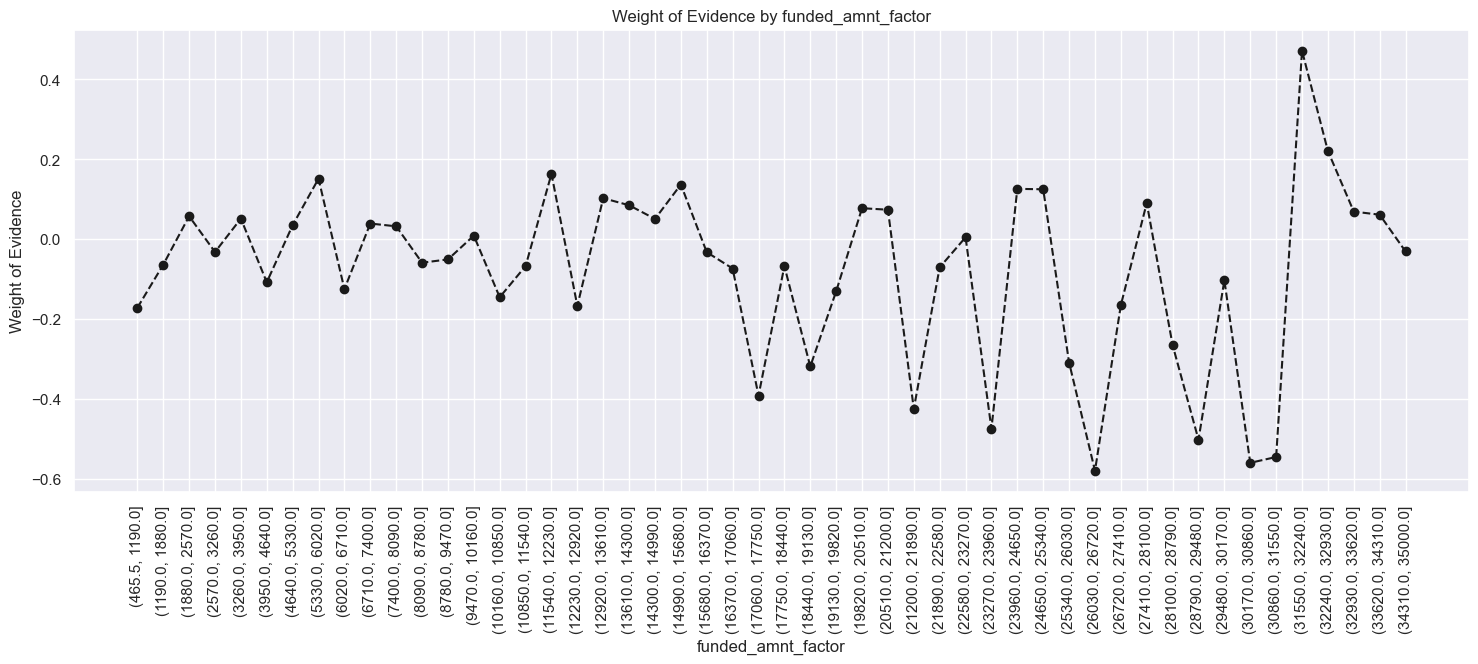

In [187]:
plot_by_woe(df_temp,90)

```
There seem to be no association whatsoever between funded amount and WoE, since varity differently but in a horizontal trend
```

In [188]:
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'],50)
df_temp = woe_ordered_contin(df_inputs_prepr, 'mths_since_earliest_cr_line_factor', df_targets_prepr)
df_temp

,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.587, 11.74]",5,1.000000,0.000054,5.0,0.0,0.000059,0.000000,inf,NaN,NaN,inf
1,"(11.74, 23.48]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(23.48, 35.22]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(35.22, 46.96]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,"(46.96, 58.7]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
5,"(58.7, 70.44]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
6,"(70.44, 82.18]",182,0.945055,0.001952,172.0,10.0,0.002042,0.001108,0.611578,NaN,NaN,inf
7,"(82.18, 93.92]",508,0.927165,0.005447,471.0,37.0,0.005592,0.004099,0.310609,0.017890,0.300969,inf
8,"(93.92, 105.66]",715,0.881119,0.007667,630.0,85.0,0.007480,0.009416,-0.230263,0.046046,0.540872,inf
9,"(105.66, 117.4]",1268,0.870662,0.013597,1104.0,164.0,0.013107,0.018168,-0.326502,0.010456,0.096240,inf


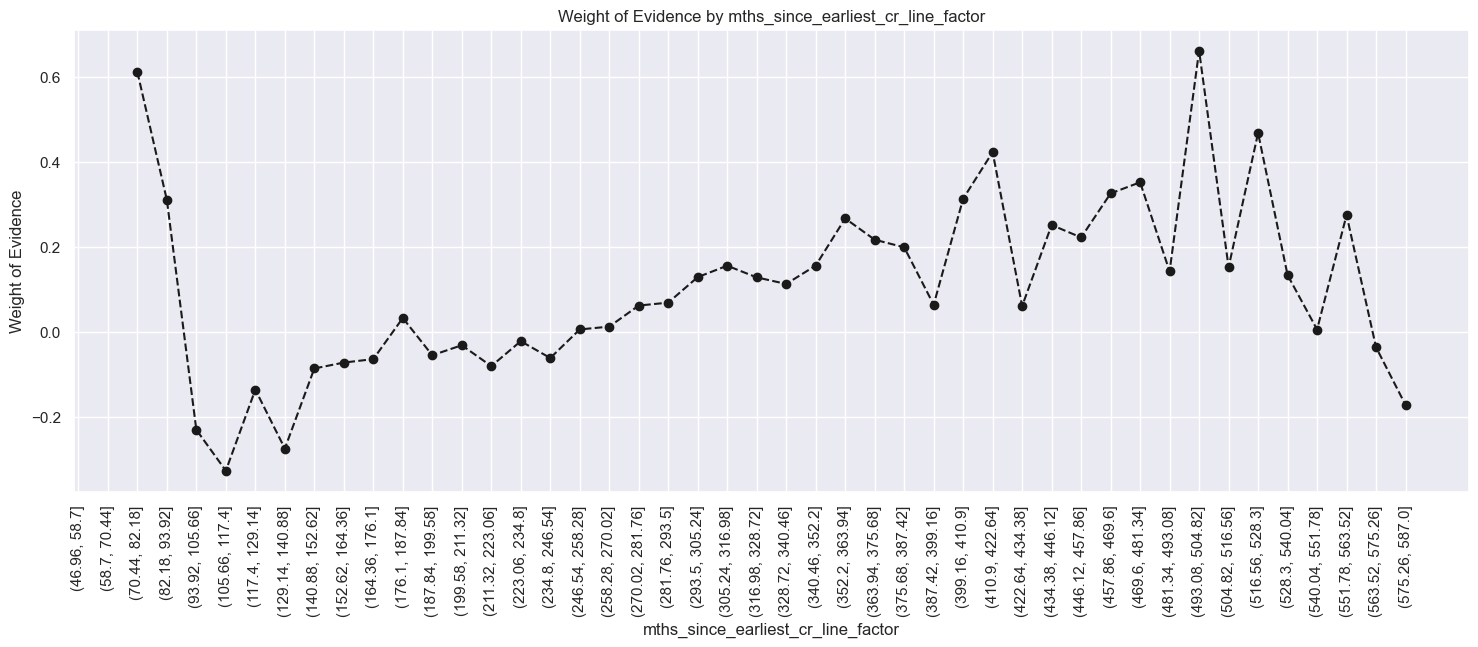

In [189]:
plot_by_woe(df_temp,90)

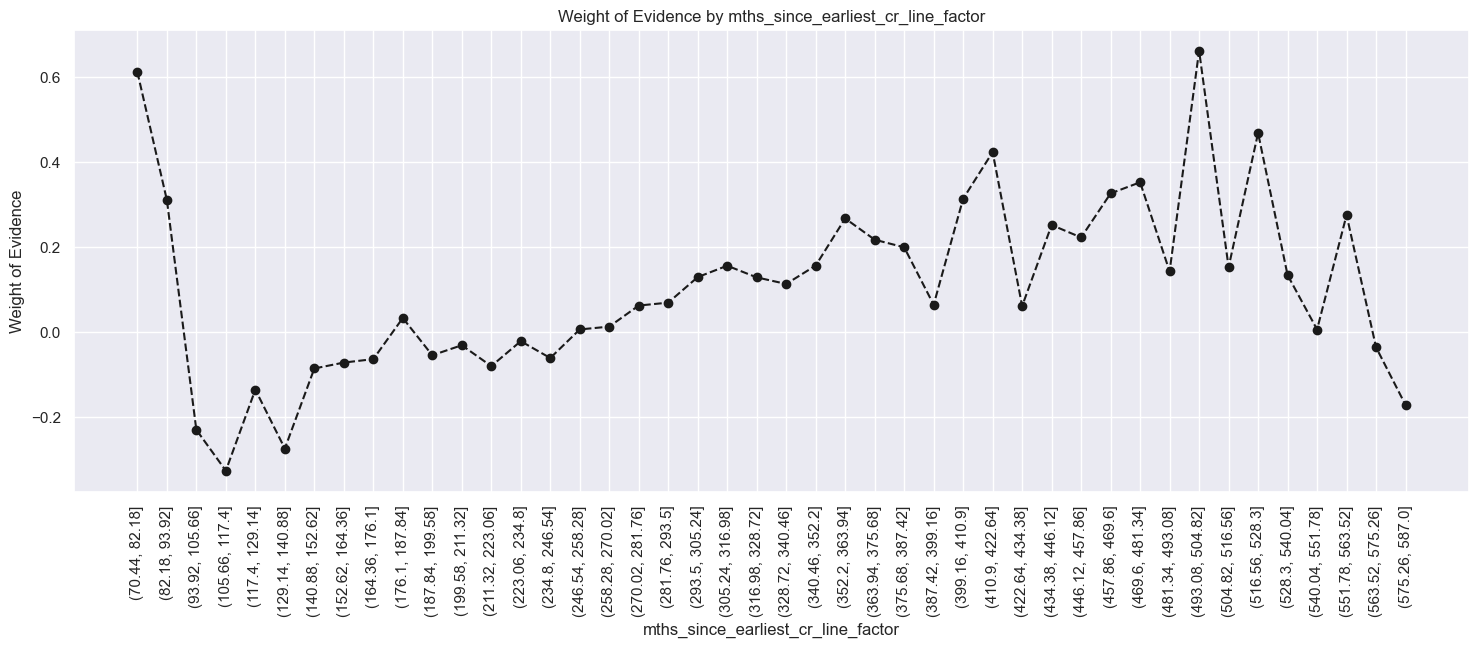

In [190]:
plot_by_woe(df_temp.iloc[6:,:],90)

In [191]:
mths_cr_line_ranges = [(range(140), 'mths_since_earliest_cr_line:<140'),
                       (range(140, 165), 'mths_since_earliest_cr_line:141-164'),
                       (range(165,247), 'mths_since_earliest_cr_line:165-247'),
                       (range(248,270), 'mths_since_earliest_cr_line:248-270'),
                       (range(271,353), 'mths_since_earliest_cr_line:271-352'),
                       (range(353, int(df_inputs_prepr['mths_since_earliest_cr_line'].max())), 'mths_since_earliest_cr_line:>352')]

create_dummy_col_with_range(df_inputs_prepr, 'mths_since_earliest_cr_line', mths_cr_line_ranges)

In [192]:
df_inputs_prepr.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,int_rate:15.74-20.281,int_rate:>20.281,funded_amnt_factor,mths_since_earliest_cr_line_factor,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,...,0,0,"(32240.0, 32930.0]","(187.84, 199.58]",0,0,1,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,...,0,1,"(10850.0, 11540.0]","(164.36, 176.1]",0,0,1,0,0,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,...,0,0,"(29480.0, 30170.0]","(187.84, 199.58]",0,0,1,0,0,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,...,0,0,"(14300.0, 14990.0]","(105.66, 117.4]",1,0,0,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,...,0,0,"(14990.0, 15680.0]","(363.94, 375.68]",0,0,0,0,0,1


In [193]:
df_temp = woe_ordered_contin(df_inputs_prepr, 'delinq_2yrs', df_targets_prepr)
df_temp

,delinq_2yrs,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,76566,0.902646,0.821021,69112.0,7454.0,0.820515,0.825745,-0.006353,NaN,NaN,inf
1,1.0,11297,0.905727,0.121138,10232.0,1065.0,0.121477,0.117979,0.029214,0.003081,0.035568,inf
2,2.0,3192,0.901942,0.034228,2879.0,313.0,0.034180,0.034674,-0.014336,0.003785,0.043550,inf
3,3.0,1134,0.914462,0.012160,1037.0,97.0,0.012312,0.010746,0.136045,0.012520,0.150381,inf
4,4.0,510,0.905882,0.005469,462.0,48.0,0.005485,0.005317,0.031033,0.008580,0.105012,inf
5,5.0,270,0.922222,0.002895,249.0,21.0,0.002956,0.002326,0.239599,0.016340,0.208567,inf
6,6.0,128,0.882812,0.001373,113.0,15.0,0.001342,0.001662,-0.213993,0.039410,0.453593,inf
7,7.0,67,0.910448,0.000718,61.0,6.0,0.000724,0.000665,0.085783,0.027635,0.299777,inf
8,8.0,29,0.896552,0.000311,26.0,3.0,0.000309,0.000332,-0.073847,0.013896,0.159630,inf
9,9.0,22,0.954545,0.000236,21.0,1.0,0.000249,0.000111,0.811191,0.057994,0.885038,inf


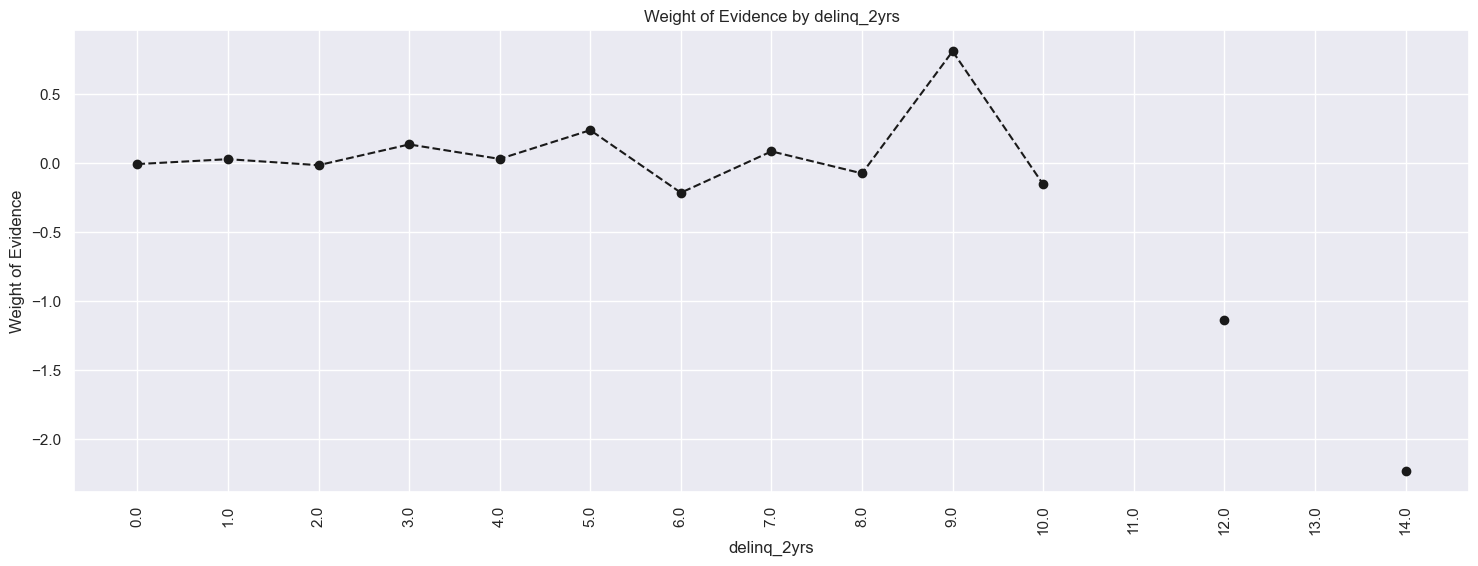

In [194]:
plot_by_woe(df_temp, 90)

In [195]:
delinq_2yrs_ranges = [((0, 0), 'delinq_2yrs:0'),
                      ((1, 3), 'delinq_2yrs:1-3'),
                      ((4, float('inf')), 'delinq_2yrs:>=4')]

create_dummy_col_wo_range(df_inputs_prepr, 'delinq_2yrs', delinq_2yrs_ranges) 

In [196]:
df_temp = woe_ordered_contin(df_inputs_prepr, 'inq_last_6mths', df_targets_prepr)
df_temp

,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,48295,0.921627,0.517870,44510.0,3785.0,0.528434,0.419298,0.231337,NaN,NaN,inf
1,1.0,25985,0.896363,0.278639,23292.0,2693.0,0.276529,0.298327,-0.075877,0.025264,0.307214,inf
2,2.0,11611,0.875205,0.124505,10162.0,1449.0,0.120646,0.160518,-0.285549,0.021159,0.209673,inf
3,3.0,5086,0.856272,0.054537,4355.0,731.0,0.051704,0.080979,-0.448665,0.018932,0.163115,inf
4,4.0,1431,0.856744,0.015345,1226.0,205.0,0.014555,0.022710,-0.444829,0.000471,0.003836,inf
5,5.0,551,0.843920,0.005908,465.0,86.0,0.005521,0.009527,-0.545641,0.012823,0.100812,inf
6,6.0,211,0.796209,0.002263,168.0,43.0,0.001995,0.004763,-0.870567,0.047712,0.324926,inf
7,7.0,36,0.527778,0.000386,19.0,17.0,0.000226,0.001883,-2.122105,0.268431,1.251538,inf
8,8.0,21,0.523810,0.000225,11.0,10.0,0.000131,0.001108,-2.138021,0.003968,0.015915,inf
9,9.0,7,0.428571,0.000075,3.0,4.0,0.000036,0.000443,-2.521013,0.095238,0.382992,inf


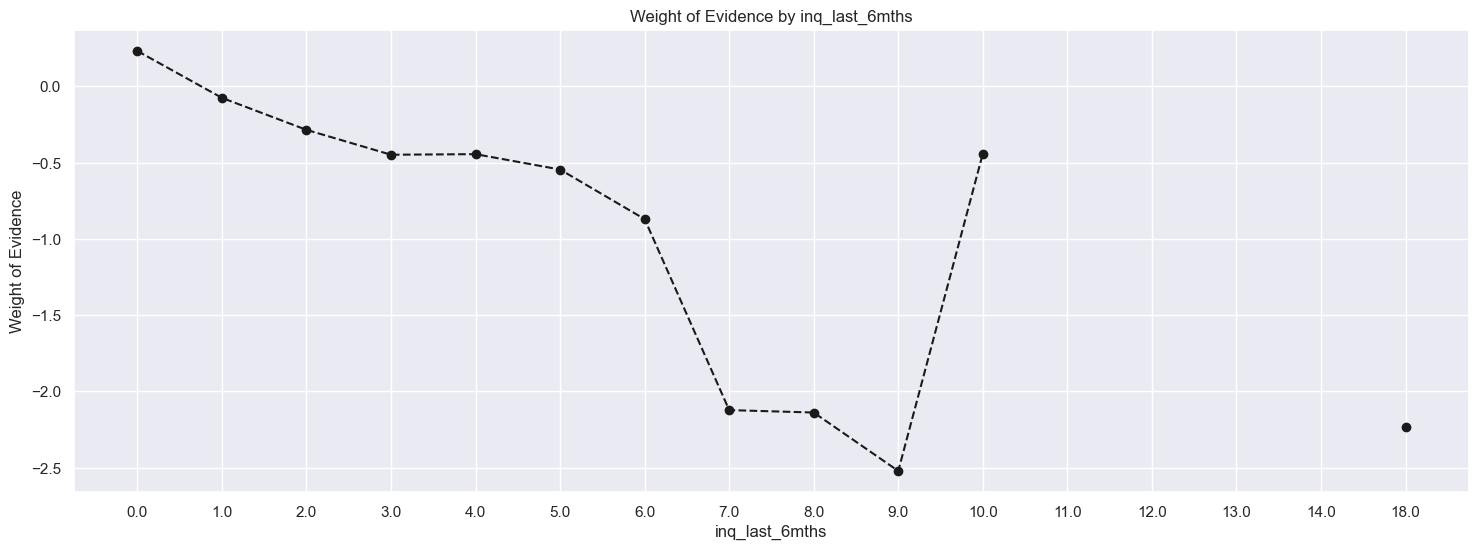

In [197]:
plot_by_woe(df_temp)

In [198]:
inq_last_6mths_ranges = [((0, 0), 'inq_last_6mths:0'),
                         ((1, 2), 'inq_last_6mths:1-2'),
                         ((3, 6), 'inq_last_6mths:3-6'),
                         ((6, float('inf')), 'inq_last_6mths:>6')]


create_dummy_col_wo_range(df_inputs_prepr, 'inq_last_6mths', inq_last_6mths_ranges)

In [199]:
df_temp = woe_ordered_contin(df_inputs_prepr, 'open_acc', df_targets_prepr)
df_temp

,open_acc,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,7,1.000000,0.000075,7.0,0.0,0.000083,0.000000,inf,NaN,NaN,inf
1,1.0,32,0.937500,0.000343,30.0,2.0,0.000356,0.000222,0.474719,0.062500,inf,inf
2,2.0,334,0.841317,0.003582,281.0,53.0,0.003336,0.005871,-0.565268,0.096183,1.039987,inf
3,3.0,1122,0.861854,0.012031,967.0,155.0,0.011480,0.017171,-0.402558,0.020536,0.162711,inf
4,4.0,2560,0.899219,0.027451,2302.0,258.0,0.027330,0.028581,-0.044757,0.037365,0.357801,inf
5,5.0,4403,0.901431,0.047214,3969.0,434.0,0.047121,0.048078,-0.020106,0.002212,0.024651,inf
6,6.0,6216,0.901062,0.066655,5601.0,615.0,0.066496,0.068129,-0.024253,0.000369,0.004147,inf
7,7.0,7433,0.898830,0.079704,6681.0,752.0,0.079319,0.083306,-0.049044,0.002232,0.024792,inf
8,8.0,8314,0.906062,0.089151,7533.0,781.0,0.089434,0.086518,0.033142,0.007233,0.082187,inf
9,9.0,8768,0.901688,0.094020,7906.0,862.0,0.093862,0.095491,-0.017209,0.004374,0.050352,inf


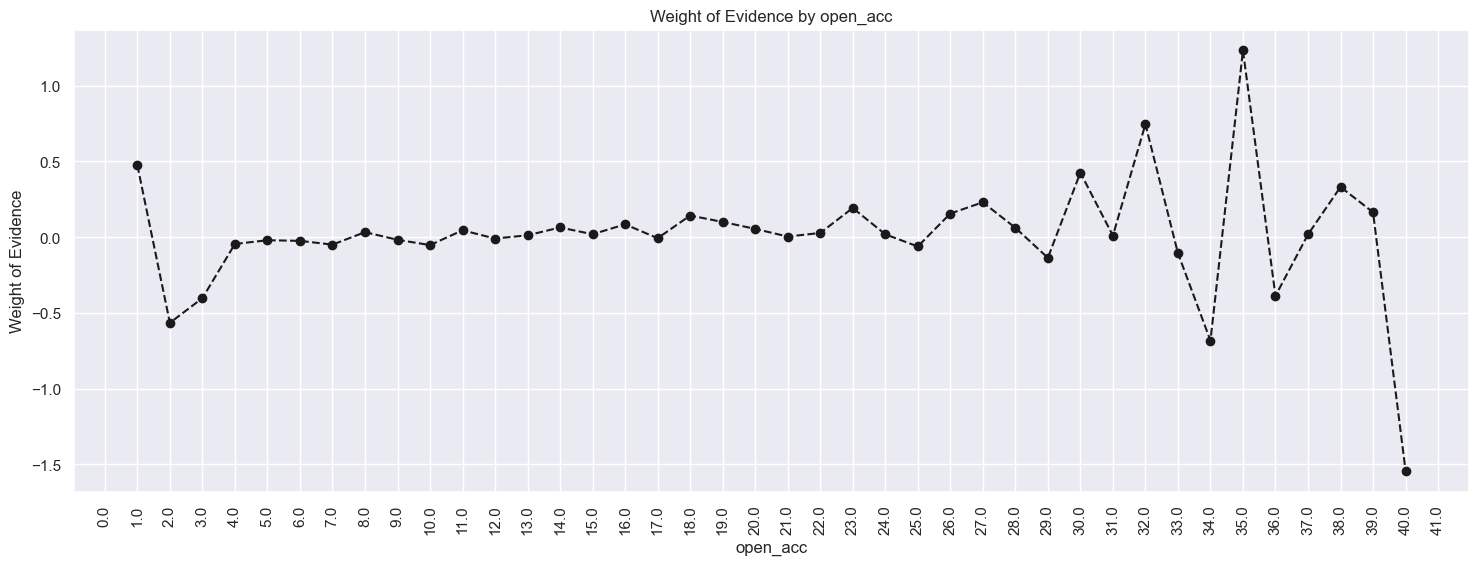

In [200]:
plot_by_woe(df_temp, 90)

In [201]:
open_acc_ranges = [((0, 0), 'open_acc:0'),
                   ((1, 3), 'open_acc:1-3'),
                   ((4, 12), 'open_acc:4-12'),
                   ((13, 17), 'open_acc:13-17'),
                   ((18, 22), 'open_acc:18-22'),
                   ((23, 25), 'open_acc:23-25'),
                   ((26, 30), 'open_acc:26-30'),
                   ((31, float('inf')), 'open_acc:>=31')]

create_dummy_col_wo_range(df_inputs_prepr, 'open_acc', open_acc_ranges)

In [202]:
df_temp = woe_ordered_contin(df_inputs_prepr, 'pub_rec', df_targets_prepr)
df_temp

,pub_rec,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,80923,0.901412,0.867742,72945.0,7978.0,0.866022,0.883793,-0.020313,NaN,NaN,inf
1,1.0,10670,0.914902,0.114415,9762.0,908.0,0.115897,0.100587,0.141677,0.013489,0.161990,inf
2,2.0,1097,0.917046,0.011763,1006.0,91.0,0.011943,0.010081,0.169547,0.002145,0.027870,inf
3,3.0,331,0.924471,0.003549,306.0,25.0,0.003633,0.002769,0.271378,0.007425,0.101831,inf
4,4.0,112,0.857143,0.001201,96.0,16.0,0.001140,0.001772,-0.441572,0.067328,0.712950,inf
5,5.0,73,0.917808,0.000783,67.0,6.0,0.000795,0.000665,0.179602,0.060665,0.621174,inf
6,6.0,19,1.000000,0.000204,19.0,0.0,0.000226,0.000000,inf,0.082192,inf,inf
7,7.0,14,0.785714,0.000150,11.0,3.0,0.000131,0.000332,-0.934048,0.214286,inf,inf
8,8.0,5,1.000000,0.000054,5.0,0.0,0.000059,0.000000,inf,0.214286,inf,inf
9,9.0,2,1.000000,0.000021,2.0,0.0,0.000024,0.000000,inf,0.000000,NaN,inf


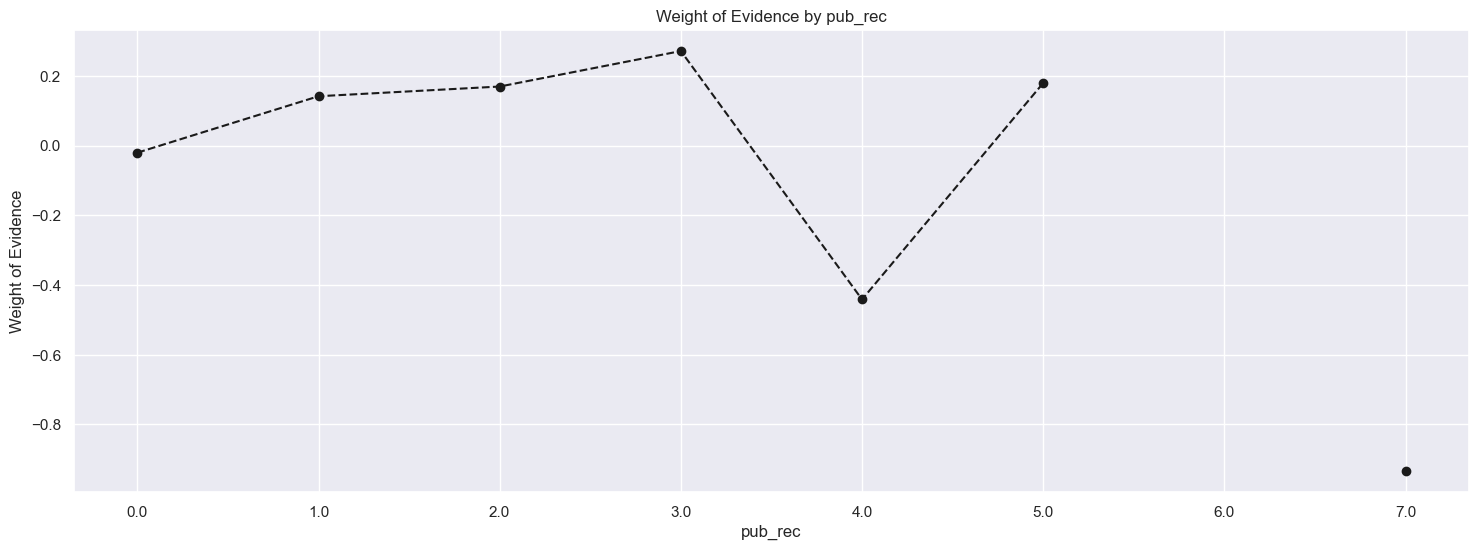

In [203]:
plot_by_woe(df_temp)

In [204]:
pub_rec_ranges = [((0, 2), 'pub_rec:0-2'),
                  ((3, 4), 'pub_rec:3-4'),
                  ((5, float('inf')), 'pub_rec:>=5')]

create_dummy_col_wo_range(df_inputs_prepr, 'pub_rec', pub_rec_ranges)

In [205]:
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'],50)
df_temp = woe_ordered_contin(df_inputs_prepr, 'total_acc_factor', df_targets_prepr)
df_temp

,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.156, 3.12]",125,0.784000,0.001340,98.0,27.0,0.001163,0.002991,-0.944200,NaN,NaN,inf
1,"(3.12, 6.24]",1499,0.865911,0.016074,1298.0,201.0,0.015410,0.022267,-0.368056,0.081911,0.576144,inf
2,"(6.24, 9.36]",3715,0.884522,0.039836,3286.0,429.0,0.039012,0.047524,-0.197362,0.018612,0.170694,inf
3,"(9.36, 12.48]",6288,0.889313,0.067427,5592.0,696.0,0.066390,0.077102,-0.149588,0.004791,0.047773,inf
4,"(12.48, 15.6]",8289,0.900832,0.088883,7467.0,822.0,0.088650,0.091060,-0.026823,0.011519,0.122766,inf
5,"(15.6, 18.72]",9843,0.901351,0.105547,8872.0,971.0,0.105331,0.107566,-0.021002,0.000519,0.005821,inf
6,"(18.72, 21.84]",10270,0.904869,0.110126,9293.0,977.0,0.110329,0.108231,0.019199,0.003517,0.040201,inf
7,"(21.84, 24.96]",9971,0.905827,0.106920,9032.0,939.0,0.107230,0.104021,0.030383,0.000958,0.011184,inf
8,"(24.96, 28.08]",11873,0.904995,0.127315,10745.0,1128.0,0.127567,0.124958,0.020663,0.000832,0.009719,inf
9,"(28.08, 31.2]",7289,0.904925,0.078160,6596.0,693.0,0.078309,0.076770,0.019858,0.000069,0.000806,inf


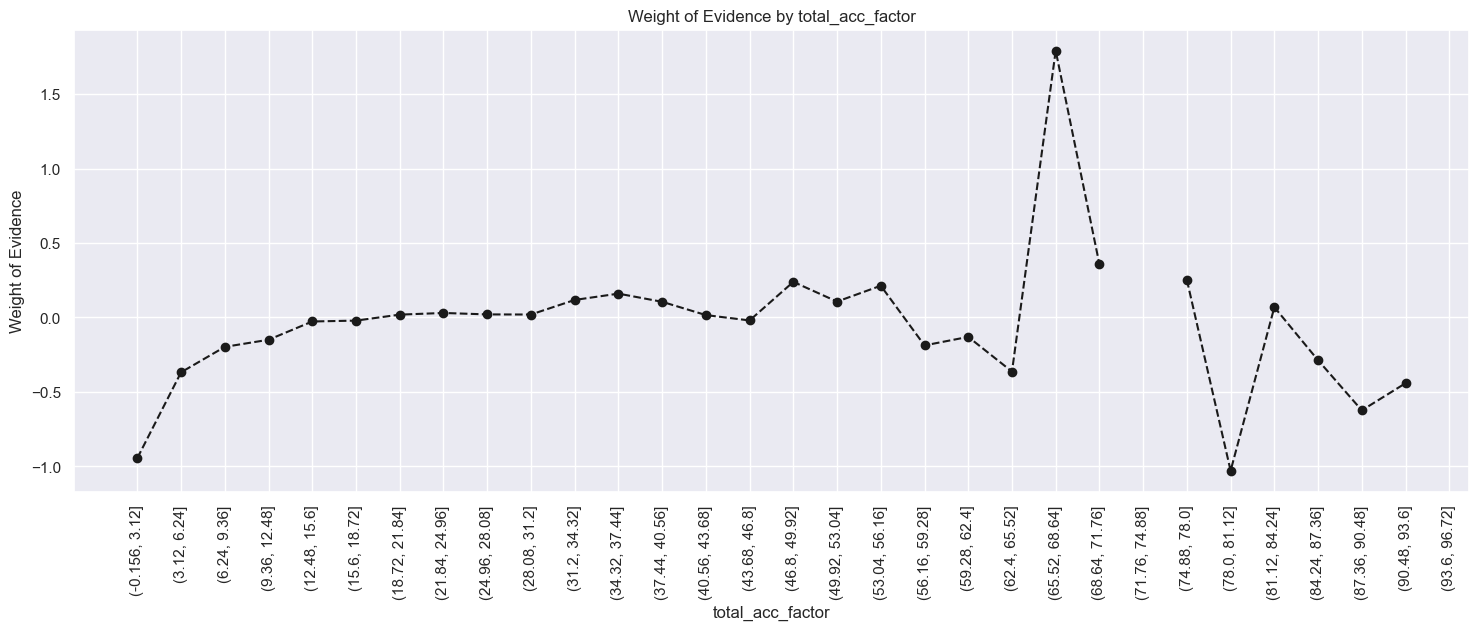

In [206]:
plot_by_woe(df_temp, 90)

In [207]:
total_acc_ranges = [((0, 27), 'total_acc:<=27'),
                    ((28, 51), 'total_acc:28-51'),
                    ((52, float('inf')), 'total_acc:>=52')]

create_dummy_col_wo_range(df_inputs_prepr, 'total_acc', total_acc_ranges)

In [208]:
df_temp = woe_ordered_contin(df_inputs_prepr, 'acc_now_delinq', df_targets_prepr)
df_temp

,acc_now_delinq,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,92871,0.903156,0.995861,83877.0,8994.0,0.995809,0.996344,-0.000537,NaN,NaN,0.000185
1,1.0,360,0.916667,0.003860,330.0,30.0,0.003918,0.003323,0.164564,0.013511,0.165102,0.000185
2,2.0,22,0.909091,0.000236,20.0,2.0,0.000237,0.000222,0.069254,0.007576,0.095310,0.000185
3,3.0,4,0.750000,0.000043,3.0,1.0,0.000036,0.000111,-1.134719,0.159091,1.203973,0.000185


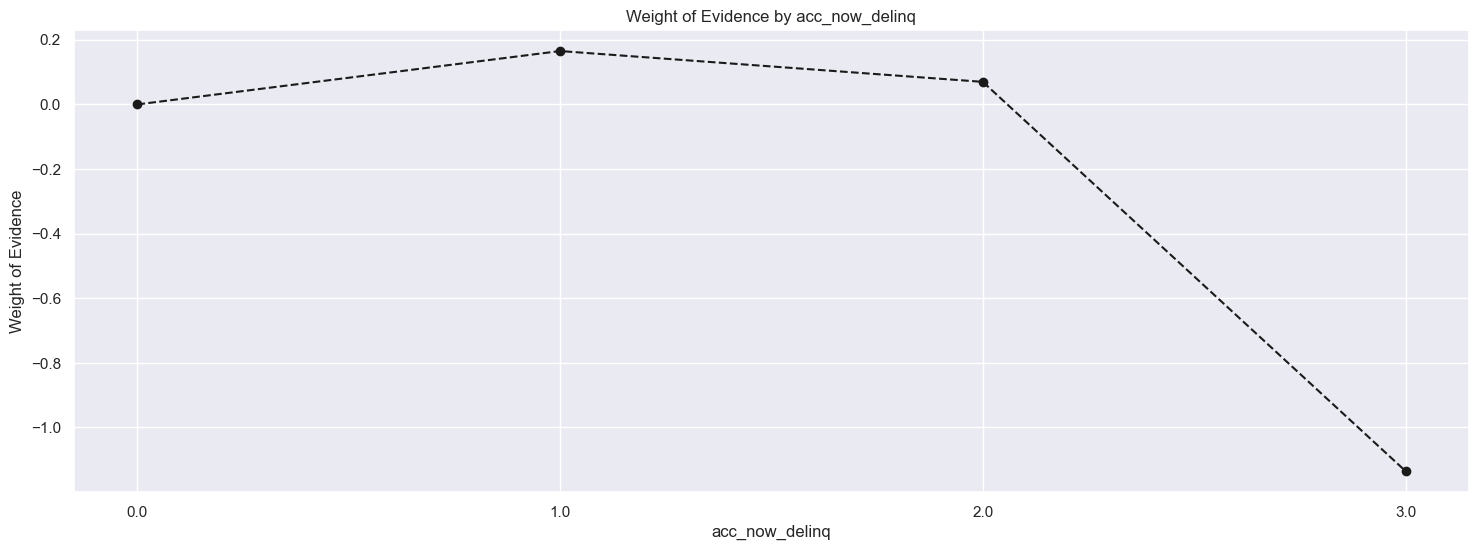

In [209]:
plot_by_woe(df_temp)

In [210]:
acc_now_delinq_ranges = [((0, 0), 'acc_now_delinq:0'),
                         ((1, float('inf')), 'acc_now_delinq:>=1')]

create_dummy_col_wo_range(df_inputs_prepr, 'acc_now_delinq', acc_now_delinq_ranges)

In [211]:
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
df_temp = woe_ordered_contin(df_inputs_prepr, 'total_rev_hi_lim_factor', df_targets_prepr)
df_temp

,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-2013.133, 1006.566]",238,0.844538,0.002552,201.0,37.0,0.002386,0.004099,-0.540944,NaN,NaN,inf
1,"(1006.566, 2013.133]",678,0.831858,0.007270,564.0,114.0,0.006696,0.012629,-0.634475,0.012679,0.093531,inf
2,"(2013.133, 3019.7]",1121,0.859054,0.012021,963.0,158.0,0.011433,0.017503,-0.425873,0.027196,0.208603,inf
3,"(3019.7, 4026.266]",1461,0.889117,0.015666,1299.0,162.0,0.015422,0.017946,-0.151577,0.030063,0.274295,inf
4,"(4026.266, 5032.832]",2163,0.882571,0.023194,1909.0,254.0,0.022664,0.028138,-0.216331,0.006547,0.064753,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(2008100.168, 2009106.734]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1996,"(2009106.734, 2010113.301]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1997,"(2010113.301, 2011119.867]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1998,"(2011119.867, 2012126.434]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


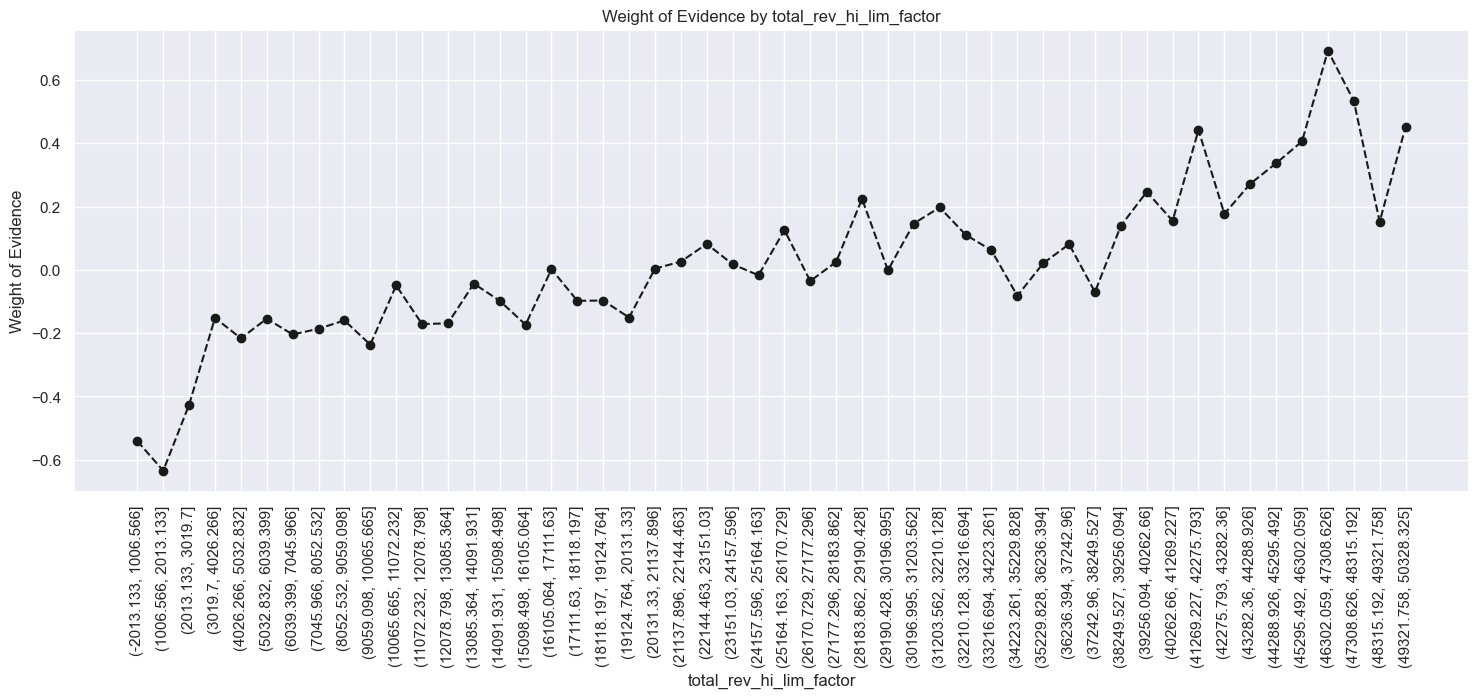

In [212]:
plot_by_woe(df_temp.iloc[: 50, : ], 90)

In [213]:
total_rev_lim_ranges = [((0, 5000), 'total_rev_hi_lim:<=5K'),
                        ((5000, 10000), 'total_rev_hi_lim:5K-10K'),
                        ((10000, 20000), 'total_rev_hi_lim:10K-20K'),
                        ((20000, 30000), 'total_rev_hi_lim:20K-30K'),
                        ((30000, 40000), 'total_rev_hi_lim:30K-40K'),
                        ((40000, 55000), 'total_rev_hi_lim:40K-55K'),
                        ((55000, 95000), 'total_rev_hi_lim:55K-95K'),
                        ((95000, float('inf')), 'total_rev_hi_lim:>95K')]

create_dummy_col_wo_range(df_inputs_prepr, 'total_rev_hi_lim', total_rev_lim_ranges, method = 'greater')

In [214]:
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)
df_temp = woe_ordered_contin(df_inputs_prepr, 'installment_factor', df_targets_prepr)
df_temp

,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(14.369, 43.585]",485,0.874227,0.005201,424.0,61.0,0.005034,0.006758,-0.294471,NaN,NaN,inf
1,"(43.585, 71.41]",1246,0.907705,0.013361,1131.0,115.0,0.013428,0.012740,0.052594,0.033478,0.347066,inf
2,"(71.41, 99.235]",1731,0.903524,0.018562,1564.0,167.0,0.018568,0.018500,0.003677,0.004181,0.048917,inf
3,"(99.235, 127.06]",2292,0.907941,0.024577,2081.0,211.0,0.024706,0.023374,0.055415,0.004417,0.051738,inf
4,"(127.06, 154.885]",2602,0.896234,0.027901,2332.0,270.0,0.027686,0.029910,-0.077271,0.011707,0.132686,inf
5,"(154.885, 182.71]",4133,0.905880,0.044318,3744.0,389.0,0.044450,0.043093,0.030999,0.009646,0.108271,inf
6,"(182.71, 210.535]",4109,0.913361,0.044061,3753.0,356.0,0.044557,0.039437,0.122049,0.007481,0.091050,inf
7,"(210.535, 238.36]",3730,0.910188,0.039997,3395.0,335.0,0.040306,0.037111,0.082597,0.003173,0.039452,inf
8,"(238.36, 266.185]",4660,0.913948,0.049969,4259.0,401.0,0.050564,0.044422,0.129497,0.003761,0.046900,inf
9,"(266.185, 294.01]",4975,0.903719,0.053347,4496.0,479.0,0.053378,0.053063,0.005912,0.010230,0.123585,inf


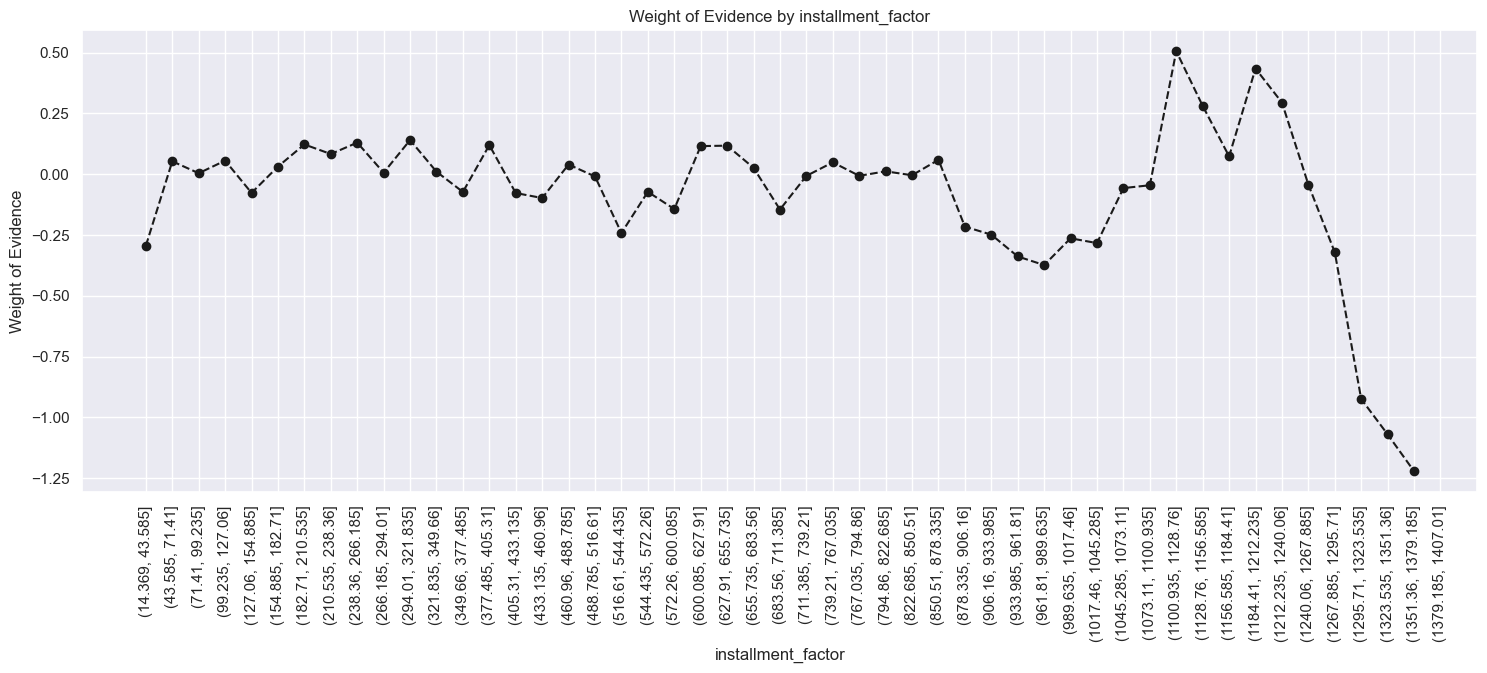

In [215]:
plot_by_woe(df_temp, 90)

In [216]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 100)
df_temp = woe_ordered_contin(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
df_temp.head()

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-2695.2, 79752.0]",62621,0.891155,0.671488,55805.0,6816.0,0.662531,0.755068,-0.130740,NaN,NaN,inf
1,"(79752.0, 154704.0]",26582,0.926153,0.285040,24619.0,1963.0,0.292283,0.217459,0.295714,0.034998,0.426454,inf
2,"(154704.0, 229656.0]",2916,0.936214,0.031268,2730.0,186.0,0.032411,0.020605,0.452979,0.010061,0.157266,inf
3,"(229656.0, 304608.0]",710,0.943662,0.007613,670.0,40.0,0.007954,0.004431,0.585067,0.007448,0.132088,inf
4,"(304608.0, 379560.0]",171,0.935673,0.001834,160.0,11.0,0.001900,0.001219,0.443947,0.007989,0.141120,inf


In [217]:
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, :]

In [218]:
df_inputs_prepr_temp['annual_inc_factor'] = pd.cut(df_inputs_prepr_temp['annual_inc'],50)
df_temp = woe_ordered_contin(df_inputs_prepr_temp, 'annual_inc_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(4664.8, 7504.0]",10,1.000000,0.000114,10.0,0.0,0.000127,0.000000,inf,NaN,NaN,inf
1,"(7504.0, 10208.0]",84,0.773810,0.000958,65.0,19.0,0.000823,0.002188,-0.978106,0.226190,inf,inf
2,"(10208.0, 12912.0]",123,0.813008,0.001403,100.0,23.0,0.001266,0.002649,-0.738378,0.039199,0.239728,inf
3,"(12912.0, 15616.0]",304,0.868421,0.003467,264.0,40.0,0.003341,0.004606,-0.320985,0.055413,0.417394,inf
4,"(15616.0, 18320.0]",383,0.832898,0.004368,319.0,64.0,0.004038,0.007370,-0.601746,0.035523,0.280762,inf
5,"(18320.0, 21024.0]",733,0.856753,0.008359,628.0,105.0,0.007949,0.012091,-0.419474,0.023855,0.182272,inf
6,"(21024.0, 23728.0]",704,0.867898,0.008028,611.0,93.0,0.007733,0.010709,-0.325557,0.011145,0.093918,inf
7,"(23728.0, 26432.0]",1785,0.871709,0.020356,1556.0,229.0,0.019694,0.026370,-0.291903,0.003811,0.033654,inf
8,"(26432.0, 29136.0]",1355,0.866421,0.015452,1174.0,181.0,0.014859,0.020843,-0.338379,0.005288,0.046477,inf
9,"(29136.0, 31840.0]",2292,0.864747,0.026137,1982.0,310.0,0.025086,0.035698,-0.352765,0.001674,0.014386,inf


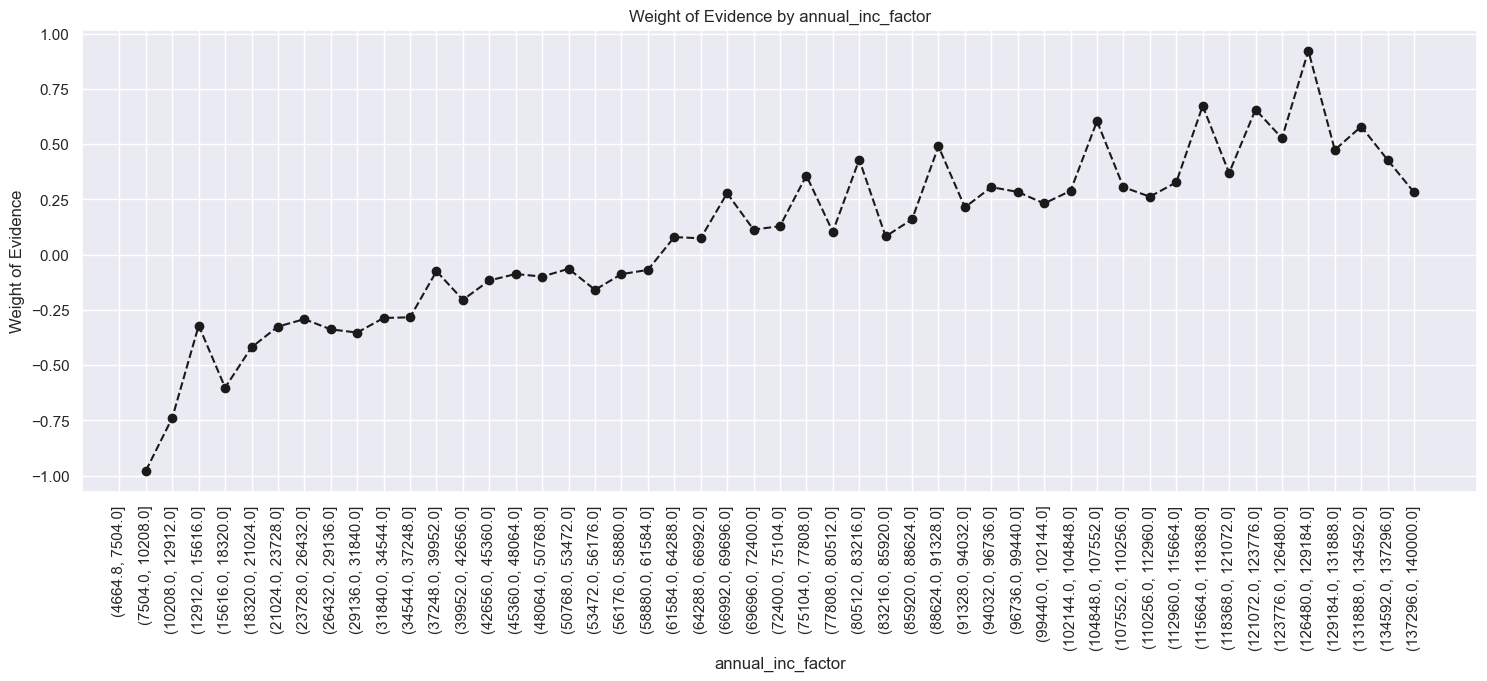

In [219]:
plot_by_woe(df_temp,90)

In [220]:
annual_inc_ranges = [((0, 20000), 'annual_inc:<20K'),
                     ((20000, 30000), 'annual_inc:20K-30K'),
                     ((30000, 40000), 'annual_inc:30K-40K'),
                     ((40000, 50000), 'annual_inc:40K-50K'),
                     ((50000, 60000), 'annual_inc:50K-60K'),
                     ((60000, 70000), 'annual_inc:60K-70K'),
                     ((70000, 80000), 'annual_inc:70K-80K'),
                     ((80000, 90000), 'annual_inc:80K-90K'),
                     ((90000, 100000), 'annual_inc:90K-100K'),
                     ((100000, 120000), 'annual_inc:100K-120K'),
                     ((120000, 140000), 'annual_inc:120K-140K'),
                     ((140000, float('inf')), 'annual_inc:>140K')]

create_dummy_col_wo_range(df_inputs_prepr, 'annual_inc', annual_inc_ranges, method = 'greater');

In [221]:
df_inputs_prepr.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,...,0,0,0,1,0,0,0,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,...,0,0,1,0,0,0,0,0,0,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,...,0,0,0,0,0,0,0,0,0,1
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,...,0,0,0,1,0,0,0,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,...,0,0,0,0,0,1,0,0,0,0


In [222]:
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_contin(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.17, 3.4]",1348,0.890208,0.031283,1200.0,148.0,0.030783,0.036018,-0.157056,NaN,NaN,inf
1,"(3.4, 6.8]",1890,0.898942,0.043861,1699.0,191.0,0.043584,0.046483,-0.064399,0.008734,0.092657,inf
2,"(6.8, 10.2]",3373,0.903647,0.078276,3048.0,325.0,0.078190,0.079095,-0.011505,0.004705,0.052894,inf
3,"(10.2, 13.6]",2496,0.909455,0.057924,2270.0,226.0,0.058232,0.055001,0.057080,0.005809,0.068584,inf
4,"(13.6, 17.0]",3165,0.903949,0.073449,2861.0,304.0,0.073393,0.073984,-0.008022,0.005506,0.065101,inf
5,"(17.0, 20.4]",2282,0.904470,0.052958,2064.0,218.0,0.052948,0.053054,-0.002014,0.000520,0.006007,inf
6,"(20.4, 23.8]",2115,0.909693,0.049082,1924.0,191.0,0.049356,0.046483,0.059968,0.005223,0.061982,inf
7,"(23.8, 27.2]",2755,0.905626,0.063934,2495.0,260.0,0.064004,0.063276,0.011442,0.004067,0.048526,inf
8,"(27.2, 30.6]",1929,0.906169,0.044766,1748.0,181.0,0.044841,0.044050,0.017810,0.000543,0.006368,inf
9,"(30.6, 34.0]",2453,0.907460,0.056926,2226.0,227.0,0.057103,0.055245,0.033091,0.001291,0.015281,inf


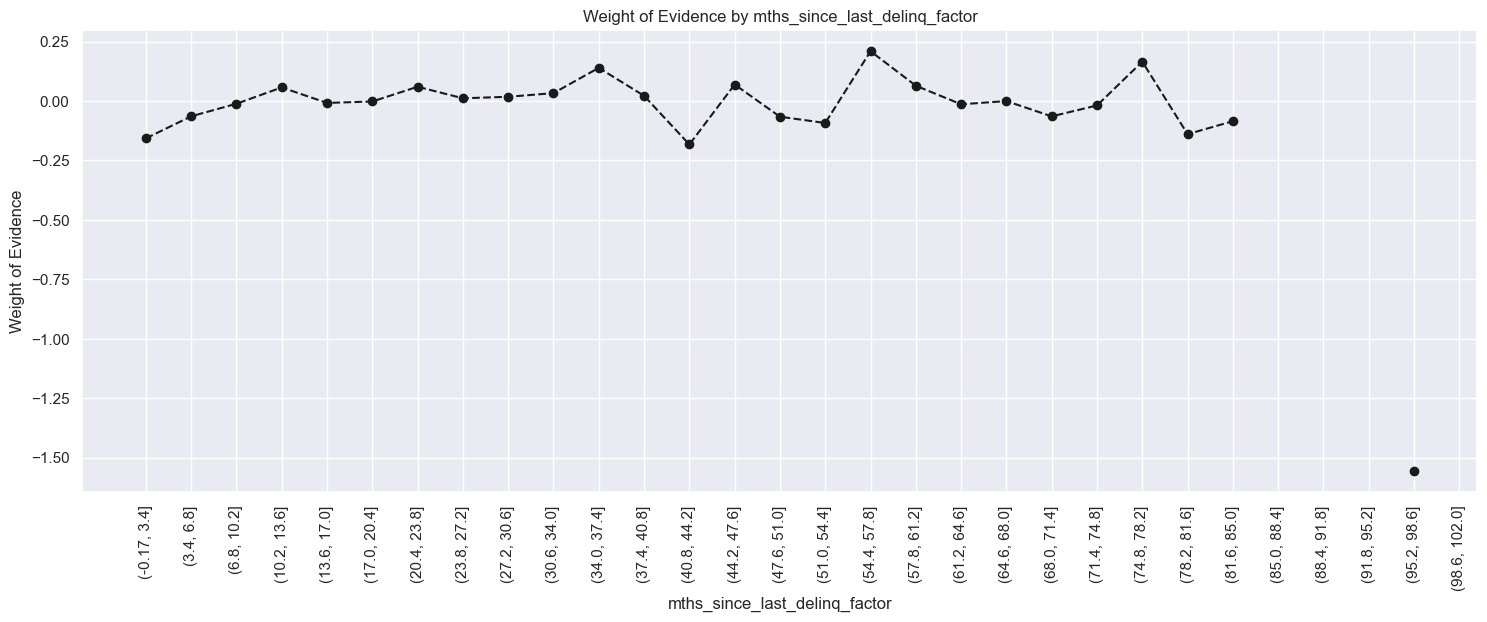

In [223]:
plot_by_woe(df_temp, 90)

In [224]:
mths_last_delinq_ranges = [((0, 3), 'mths_since_last_delinq:0-3'),
                           ((4, 30), 'mths_since_last_delinq:4-30'),
                           ((31, 56), 'mths_since_last_delinq:31-56'),
                           ((57, float('inf')), 'mths_since_last_delinq:>=57')]

create_dummy_col_wo_range(df_inputs_prepr, 'mths_since_last_delinq', mths_last_delinq_ranges)
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0);

In [225]:
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 100)
df_temp = woe_ordered_contin(df_inputs_prepr,'dti_factor', df_targets_prepr)
df_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.04, 0.4]",187,0.903743,0.002005,169.0,18.0,0.002006,0.001994,0.006196,NaN,NaN,0.036851
1,"(0.4, 0.8]",184,0.885870,0.001973,163.0,21.0,0.001935,0.002326,-0.184103,0.017874,0.190299,0.036851
2,"(0.8, 1.2]",223,0.905830,0.002391,202.0,21.0,0.002398,0.002326,0.030414,0.019960,0.214517,0.036851
3,"(1.2, 1.6]",255,0.913725,0.002734,233.0,22.0,0.002766,0.002437,0.126665,0.007896,0.096251,0.036851
4,"(1.6, 2.0]",315,0.901587,0.003378,284.0,31.0,0.003372,0.003434,-0.018344,0.012138,0.145009,0.036851
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(37.991, 38.39]",54,0.907407,0.000579,49.0,5.0,0.000582,0.000554,0.049051,0.018519,0.202941,0.036851
96,"(38.39, 38.79]",37,0.837838,0.000397,31.0,6.0,0.000368,0.000665,-0.591103,0.069570,0.640155,0.036851
97,"(38.79, 39.19]",45,0.844444,0.000483,38.0,7.0,0.000451,0.000775,-0.541655,0.006607,0.049448,0.036851
98,"(39.19, 39.59]",44,0.909091,0.000472,40.0,4.0,0.000475,0.000443,0.069254,0.064646,0.610909,0.036851


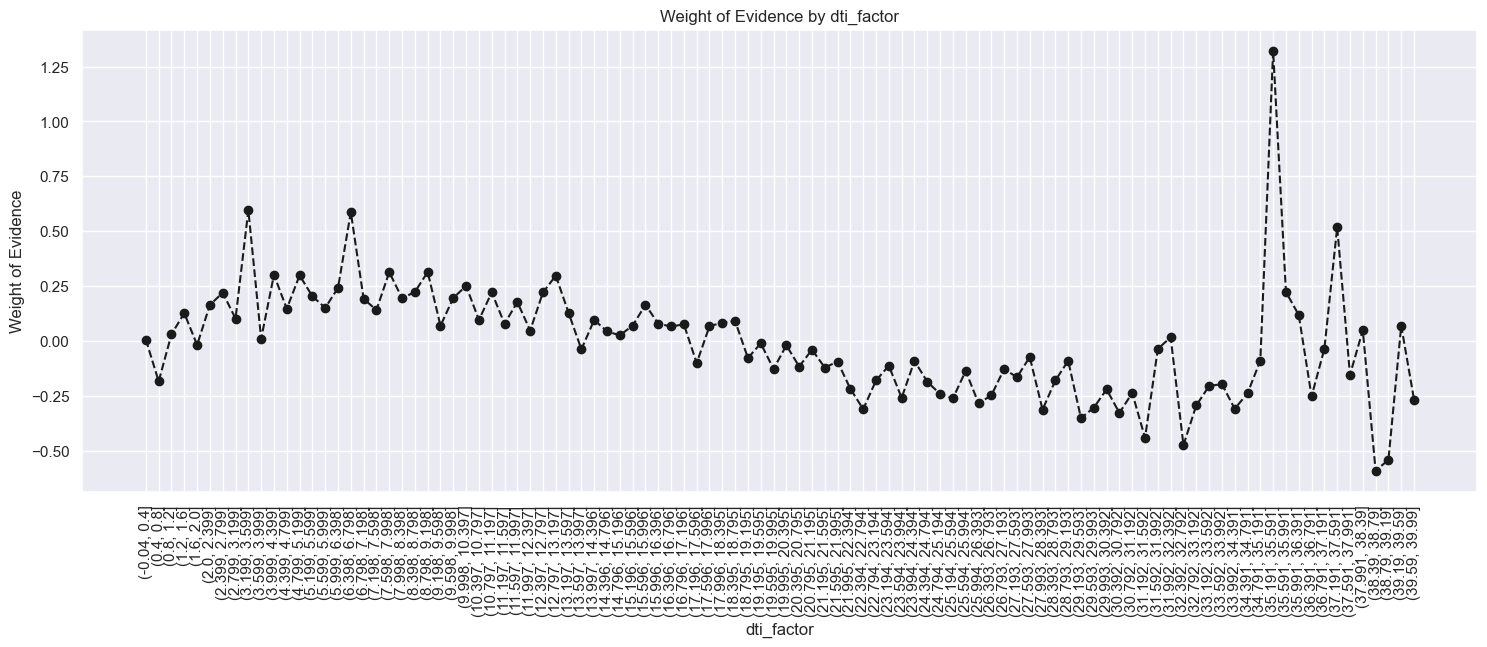

In [226]:
plot_by_woe(df_temp, 90)

In [227]:
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['dti'] <= 35, : ]

In [228]:
df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
df_temp = woe_ordered_contin(df_inputs_prepr_temp, 'dti_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.035, 0.7]",328,0.893293,0.003544,293.0,35.0,0.003505,0.003906,-0.108305,NaN,NaN,0.031693
1,"(0.7, 1.4]",393,0.916031,0.004246,360.0,33.0,0.004307,0.003683,0.156467,0.022738,0.264772,0.031693
2,"(1.4, 2.1]",536,0.901119,0.005792,483.0,53.0,0.005778,0.005915,-0.023405,0.014911,0.179872,0.031693
3,"(2.1, 2.8]",607,0.919275,0.006559,558.0,49.0,0.006676,0.005469,0.199409,0.018156,0.222814,0.031693
4,"(2.8, 3.5]",811,0.933416,0.008763,757.0,54.0,0.009056,0.006027,0.407249,0.014140,0.207841,0.031693
5,"(3.5, 4.2]",970,0.907216,0.010481,880.0,90.0,0.010528,0.010045,0.046982,0.026199,0.360267,0.031693
6,"(4.2, 4.9]",1140,0.921053,0.012318,1050.0,90.0,0.012562,0.010045,0.223606,0.013836,0.176624,0.031693
7,"(4.9, 5.6]",1370,0.921168,0.014803,1262.0,108.0,0.015098,0.012054,0.225192,0.000115,0.001586,0.031693
8,"(5.6, 6.3]",1491,0.919517,0.016111,1371.0,120.0,0.016402,0.013393,0.202674,0.001651,0.022518,0.031693
9,"(6.3, 7.0]",1722,0.934959,0.018607,1610.0,112.0,0.019261,0.012500,0.432361,0.015442,0.229687,0.031693


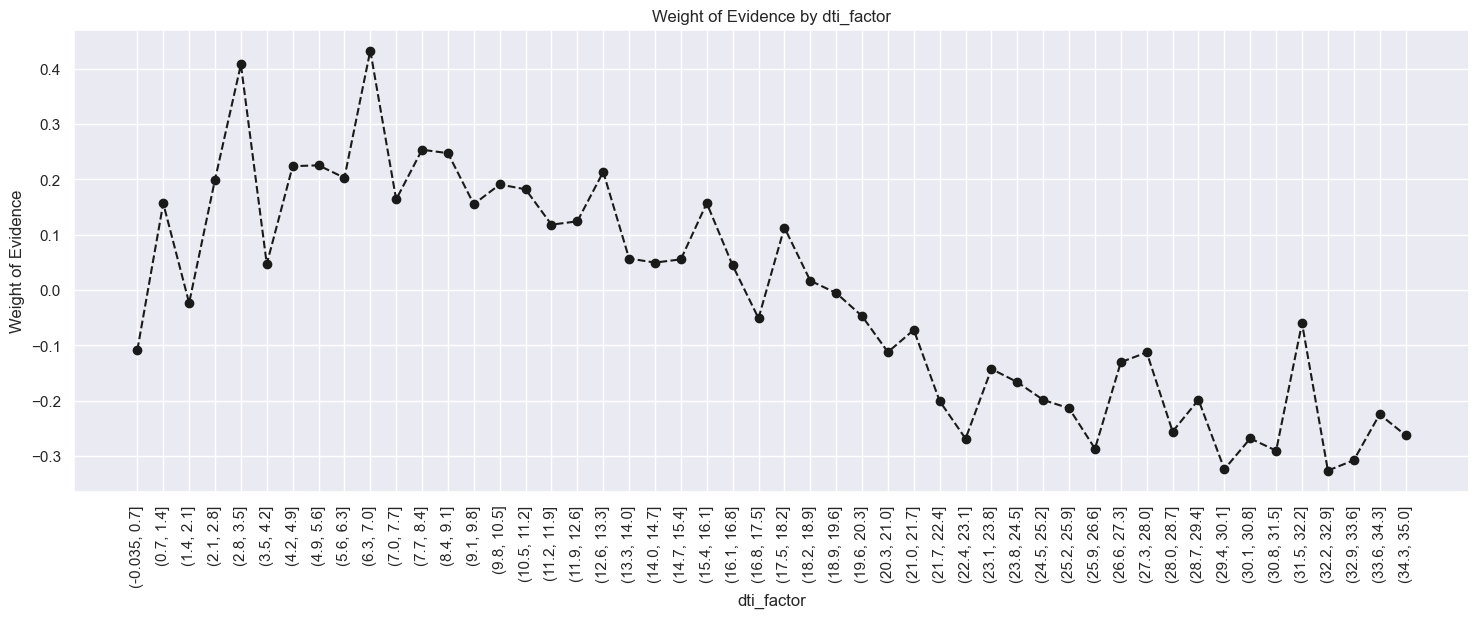

In [229]:
plot_by_woe(df_temp, 90)

In [230]:
dti_ranges = [((-float('inf'), 1.4), 'dti:<=1.4'),
              ((1.4, 3.5), 'dti:1.4-3.5'),
              ((3.5, 7.7), 'dti:3.5-7.7'),
              ((7.7, 10.5), 'dti:7.7-10.5'),
              ((10.5, 16.1), 'dti:10.5-16.1'),
              ((16.1, 20.3), 'dti:16.1-20.3'),
              ((20.3, 21.7), 'dti:20.3-21.7'),
              ((21.7, 22.4), 'dti:21.7-22.4'),
              ((22.4, 35), 'dti:22.4-35'),
              ((35, float('inf')), 'dti:>35')]

create_dummy_col_wo_range(df_inputs_prepr, 'dti', dti_ranges, method = 'greater');

In [231]:
# mths_since_last_record
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]
#sum(loan_data_temp['mths_since_last_record'].isnull())
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_contin(df_inputs_prepr_temp, 'mths_since_last_record_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

,mths_since_last_record_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.129, 2.58]",244,0.741803,0.019410,181.0,63.0,0.015794,0.056706,-1.278240,NaN,NaN,inf
1,"(2.58, 5.16]",36,0.944444,0.002864,34.0,2.0,0.002967,0.001800,0.499611,0.202641,1.777851,inf
2,"(5.16, 7.74]",39,0.923077,0.003102,36.0,3.0,0.003141,0.002700,0.151304,0.021368,0.348307,inf
3,"(7.74, 10.32]",66,0.924242,0.005250,61.0,5.0,0.005323,0.004500,0.167834,0.001166,0.016529,inf
4,"(10.32, 12.9]",42,0.904762,0.003341,38.0,4.0,0.003316,0.003600,-0.082310,0.019481,0.250144,inf
5,"(12.9, 15.48]",69,0.898551,0.005489,62.0,7.0,0.005410,0.006301,-0.152378,0.006211,0.070068,inf
6,"(15.48, 18.06]",95,0.873684,0.007557,83.0,12.0,0.007243,0.010801,-0.399668,0.024867,0.247290,inf
7,"(18.06, 20.64]",58,0.982759,0.004614,57.0,1.0,0.004974,0.000900,1.709449,0.109074,2.109117,inf
8,"(20.64, 23.22]",101,0.900990,0.008034,91.0,10.0,0.007941,0.009001,-0.125328,0.081769,1.834777,inf
9,"(23.22, 25.8]",94,0.968085,0.007478,91.0,3.0,0.007941,0.002700,1.078645,0.067095,1.203973,inf


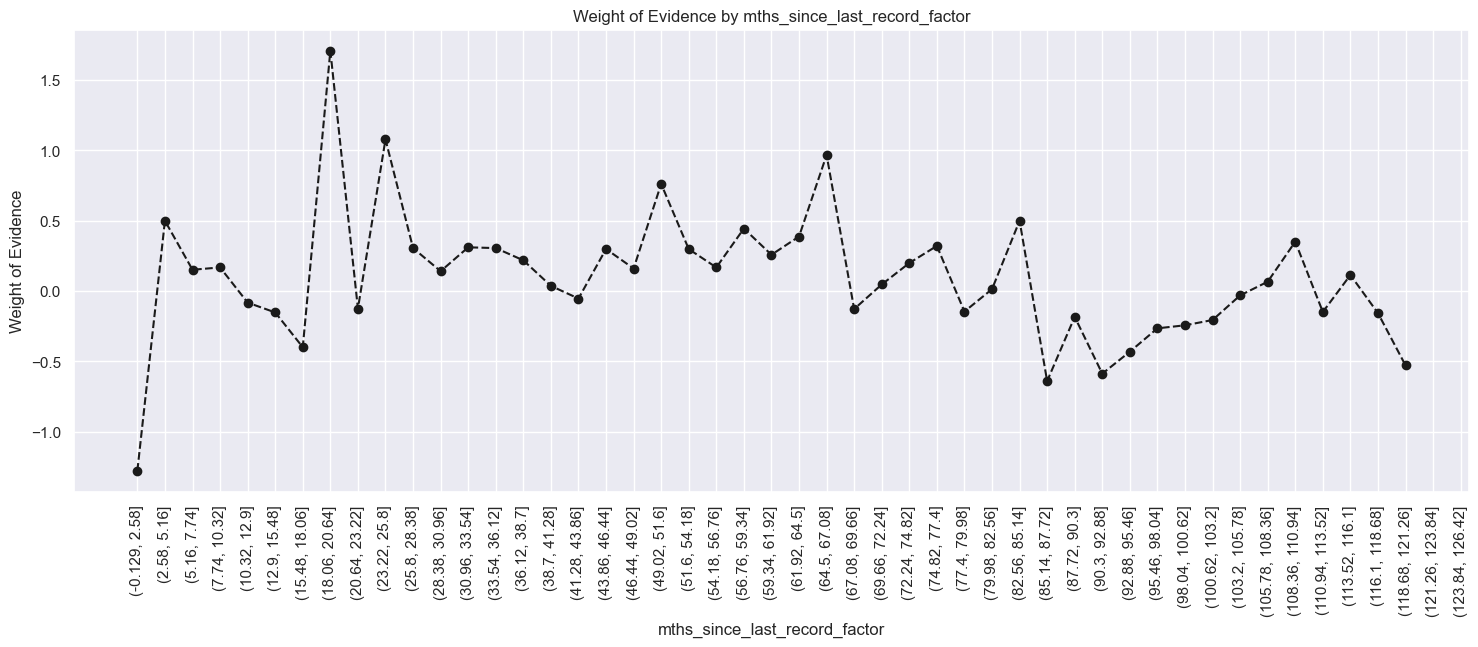

In [232]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [233]:
mths_last_record_ranges = [((0, 2), 'mths_since_last_record:0-2'),
                           ((3, 20), 'mths_since_last_record:3-20'),
                           ((21, 31), 'mths_since_last_record:21-31'),
                           ((32, 80), 'mths_since_last_record:32-80'),
                           ((81, 86), 'mths_since_last_record:81-86'),
                           ((86, float('inf')), 'mths_since_last_record:>86')]

df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
create_dummy_col_wo_range(df_inputs_prepr, 'mths_since_last_record', mths_last_record_ranges);

### Preprocessing the Test Dataset

In [143]:
# Save the process for train dataset
# loan_data_inputs_train = df_inputs_prepr

In [234]:
# Save the same dummies variable for test dataset
loan_data_inputs_test = df_inputs_prepr

In [235]:
loan_data_inputs_train.to_csv('loan_data_inputs_train.csv')
loan_data_targets_train.to_csv('loan_data_targets_train.csv')
loan_data_inputs_test.to_csv('loan_data_inputs_test.csv')
loan_data_targets_test.to_csv('loan_data_targets_test.csv')